# Proyecto final grupo 7: Clasificación binaria (aprobar o denegar préstamos)
Realizada por:
- Jaime Benedí
- Miguel Sevilla

Objetivo : Predecir si un préstamo será pagado en su totalidad o terminará en impago, ayudando a la toma de decisiones de la SBA o de la entidad financiera.

## Librerías a usar

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import joblib


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier

from torch.utils.data import DataLoader, TensorDataset

from shap import Explainer, initjs
from shap.plots import waterfall
from shap.utils import sample

## Importar los datos de Kaggle
Asumimos descargados el dataset de Kaggle.

In [2]:
ls data/

BestModelsStats.csv
SBAFiltered.csv
SBAStandarized.csv
SBAnational.csv
Should_This_Loan_be_Approved_or_Denied_A_Large_Dataset_with_Class_Assignment_Guidelines.pdf
models/
shap_explainer_mlp.joblib
shap_values_mlp.joblib
should_this_loan_be_approved_or_denied.zip
xAI/


In [3]:
DATASET_PATH : str = './data/SBAnational.csv'
DATA_PATH : str = './data/'
IMAGES_PATH : str = './images/'

In [4]:
original_dataset = pd.read_csv(DATASET_PATH, low_memory=False)

## 1. Análisis del dataset

### ¿Que tipo de problema estamos resolviendo?

Este dataset plantea un problema de **clasificación**. El objetivo es generar un modelo que, considerando unas variables descriptivas del perfil de un futuro préstamo a conceder, ser capaz de predecir si éste será capaz de devolverlo en los plazos establecidos o si es probable que caiga en _default_.

Y esas serán nuestras dos clases: _Charged Off_ o _Paid in Full_, por lo tanto específicamente es un problema de **clasificación binaria**.

Como contexto, el dataset está extraído de la Administración de Pequeños Negocios de EEUU (SBA) sobre la asignación, características y pagos de préstamos entre 1962 y 2014.

### Dimensiones de la población

In [5]:
tamPoblacional = original_dataset.shape[0]
numOriginalVariables = original_dataset.shape[1]

print(f"-- Naturaleza del conjunto original de datos --")
print(f"Número de elementos en la muestra: {tamPoblacional}")
print(f"Número de variables en la muestra: {numOriginalVariables}")

-- Naturaleza del conjunto original de datos --
Número de elementos en la muestra: 899164
Número de variables en la muestra: 27


### Explicación de los atributos

Variables del dataset:

In [6]:
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

### Variable de salida (dependiente)

#### MIS_Status

Esta será la variable de clasificación que usaremos como salida esperada. La variable es de tipo `str` e indica el estado del préstamo.

In [7]:
original_dataset['MIS_Status'].value_counts()

MIS_Status
P I F     739609
CHGOFF    157558
Name: count, dtype: int64

- `P I F` (_Paid In Full_) significa que el préstamo fue pagado correctamente y de manera completa.
- `CHGOFF` (_Charged Off_) (también _default_) significa que el préstamo no fue pagado bajo las condiciones previstas.

Obviamente, al ser la variable que usaremos para clasificar todo el dataset, además de tener dos clases nominales claras, afirmamos que es:

- **categórica**.
- **evaluable para correlación**.

### Variables de entrada (independientes)

#### LoanNr_ChkDgt

Es un identificador del préstamo concreto en un `str`. Clave primaria para distinguir los préstamos entre sí. Para este análisis resulta inútil, puesto que es único para cada elemento, es independiente a la asignación del préstamo y no condiciona el desarrollo del deudor en ninguna manera. Afirmamos que es:

- **identificador**
- **no evaluable**

#### Name

Nombre de la persona (jurídica) deudora en un `str`. Al igual que la categoría anterior, cumple los requisitos para no ser evaluada. Afirmamos que es:

- **identificador**
- **no evaluable**

#### City

Nombre de la ciudad del deudor almacenada en un `str`. Observamos la cantidad de valores distintos que existen en el dataset:

In [8]:
original_dataset['City'].value_counts()

City
LOS ANGELES                       11558
HOUSTON                           10247
NEW YORK                           7846
CHICAGO                            6036
MIAMI                              5594
                                  ...  
EL DORADO SPRINGS (ELDORADO SP        1
HUNTINDON                             1
LEBAHON                               1
WILLOW RIVER                          1
SO. OZONE PARK                        1
Name: count, Length: 32581, dtype: int64

Existen muchísimas ciudades distintas en el dataset, además que en un primer vistazo parece que la distribución de préstamos por ciudad parece muy concentrada en núcleos densos de población.

Existe una manera de agrupar ciudades: por los estados a los que pertenece, reduciendo el máximo de clases que pueden expandirse hasta 51. El problema es que ya existe una variable que hace eso. Creemos que esta es más información personal del deudor que de la naturaleza de préstamos repartidos a nivel nacional.

No la consideramos que vaya a ser evaluable.

- **categórica**
- **no evaluable**

#### State

Iniciales de los estados (EEUU) de los deudores en un `str`. Máximo 51

In [9]:
aux = original_dataset['State'].value_counts()
print(aux)
print(aux.shape[0])

State
CA    130619
TX     70458
NY     57693
FL     41212
PA     35170
OH     32622
IL     29669
MA     25272
MN     24373
NJ     24035
WA     23263
GA     22277
WI     21040
MO     20678
CO     20605
MI     20545
UT     18776
AZ     17631
NC     14294
IN     14132
MD     13269
VA     13264
CT     12229
NH     12109
IA     11996
KS     11464
OR     11051
OK      9950
LA      9576
ID      9498
TN      9403
RI      9028
MT      8749
AL      8362
NV      8024
KY      7723
MS      7686
NE      6386
AR      6341
NM      6033
ME      5944
SC      5597
VT      5454
ND      5245
SD      4431
HI      3610
WV      3287
WY      2839
AK      2405
DE      2220
DC      1613
Name: count, dtype: int64
51


Aquí las clases están acotadas a un máximo de 51, que es más razonable que la de ciudades y, a primera vista parece que está mejor distribuido que en el casos de ciudades.

- **categórica**
- **evaluable para correlación**

#### Zip

Código que representa el código postal asociado a una tarjeta de crédito o a la cuenta en la que se deposita el préstamo. Es un identificador al que no le daremos ninguna importancia porque solo sirve para asociar préstamos con cuentas bancarias y códigos bancarios. Almacenado en `str`

- **identificador**
- **no evaluable**

#### Bank

Nombre del banco asociado al préstamo, almacenado en un `str`. Observamos el número de bancos considerados en el dataset

In [10]:
original_dataset['Bank'].value_counts()

Bank
BANK OF AMERICA NATL ASSOC        86853
WELLS FARGO BANK NATL ASSOC       63503
JPMORGAN CHASE BANK NATL ASSOC    48167
U.S. BANK NATIONAL ASSOCIATION    35143
CITIZENS BANK NATL ASSOC          35054
                                  ...  
FIRST LANDMARK BANK                   1
MASON CITY NATIONAL BANK              1
FARMERS ST. BK OF CAMP POINT          1
CAPITAL BANK CORPORATION              1
DEPCO                                 1
Name: count, Length: 5802, dtype: int64

Observamos 5802 categorías. Es un número muy alto para clasificar un dataset. Además observamos inicialmente que la distribución es inicialmente con deudores correspondientes a bancos de los que nadie más proviene. Para tomar en consideración esta variable, deberíamos quitar todos estos bancos y deudores; o podríamos considerar el estado al que pertenecen dichos bancos como agrupación superior, puesto que que saldrán menos categorías (la siguiente variable). Asumimos que en términos de mercado y economía, si tiene relevancia por el porcentaje de préstamos que toma, pero no sabemos cuál sería el efecto en el objetivo de la práctica.

- **categórica**
- **no evaluable**

#### BankState

Iniciales del estado al que pertenece, almacenado en un `str`. Observamos su distribución:

In [11]:
aux = original_dataset['BankState'].value_counts()
print(aux)
print(aux.shape[0])

BankState
CA    118116
NC     79514
IL     65908
OH     58461
SD     51095
TX     47790
RI     45366
NY     39592
VA     29002
DE     24537
MN     19960
UT     18997
PA     17081
WI     15416
MO     14861
MA     13913
GA     13812
FL     13810
AL     12134
OR     11374
WA     10693
CO     10582
CT      9917
IA      9866
NJ      9436
KS      8876
MT      7860
IN      7623
SC      7472
MI      7369
OK      7326
MD      7016
NH      6807
AR      6322
MS      5942
TN      5620
NE      5337
ND      5113
LA      5062
VT      4757
NM      4422
KY      4382
NV      4325
ID      4314
DC      4003
AZ      3957
ME      3691
HI      2991
WY      2168
WV      2007
AK      1439
PR       156
GU         5
AN         1
EN         1
VI         1
Name: count, dtype: int64
56


Sorprendente salen 56 valores en vez de 51. Asumimos la existencia de bancos extranjeros, de momento.

El dataset queda clasificado de manera más simple. Además, se puede relacionar la proveniencia del deudor con la proveniencia del banco, puesto que quedan simplificados en categorías similares y no tienen que ser las mismas.

- **categórica**
- **evaluable para correlación**

#### NAICS

_North America Industry Classification System (NAICS)_ es un código que comprime información sobre la empresa (deudor). La primera observación resulta:

In [12]:
original_dataset['NAICS'].value_counts()

NAICS
0         201948
722110     27989
722211     19448
811111     14585
621210     14048
           ...  
927110         1
327410         1
314992         1
922110         1
325192         1
Name: count, Length: 1312, dtype: int64

Observamos muchas clases y el entendimiento del código es complejo. Sin embargo, consideramos importante interpretar que tipo de empresa está pidiendo un préstamo. En las guías del dataset, se explica que los dos primeros dígitos del código corresponde al campo/tipo de negocio que pertenece la empresa.
La nueva clasificación que seguiría sería:

In [13]:
tipos_industria ={
    '11' : 'Agricultura, Silvicultura, Pesca y Caza',
    '21' : 'Mineria, Canteras y Extraccion de Petroleo y Gas',
    '22' : 'Servicios Publicos',
    '23' : 'Construccion',
    '31' : 'Manufactura',
    '32' : 'Manufactura',
    '33' : 'Manufactura',
    '42' : 'Comercio Mayorista',
    '44' : 'Comercio Minorista',
    '45' : 'Comercio Minorista',
    '48' : 'Transporte y Almacenamiento',
    '49' : 'Transporte y Almacenamiento',
    '51' : 'Informacion',
    '52' : 'Finanzas y Seguros',
    '53' : 'Inmuebles y Alquileres',
    '54' : 'Servicios Profesionales, Cientificos y Tecnicos',
    '55' : 'Servicios de Gestion de Empresas',
    '56' : 'Gestion de Residuos y Servicios de Descontaminacion',
    '61' : 'Servicios Educativos',
    '62' : 'Servicios de Salud y Asistencia Social',
    '71' : 'Artes, Entretenimiento y Recreacion',
    '72' : 'Restaurantes y Hosteleria',
    '81' : 'Otros servicios (excepto Administracion Publica)',
    '92' : 'Administracion Publica'
}

abreviaturas_tipos_industria = {
    '11' : 'ASPC',
    '21' : 'MCE',
    '22' : 'SP',
    '23' : 'Construccion',
    '31' : 'Manufactura',
    '32' : 'Manufactura',
    '33' : 'Manufactura',
    '42' : 'Mayorista',
    '44' : 'Minorista',
    '45' : 'Minorista',
    '48' : 'Logistica',
    '49' : 'Logistica',
    '51' : 'Info',
    '52' : 'Seguros',
    '53' : 'Inmuebles',
    '54' : 'STEM',
    '55' : 'Gestion',
    '56' : 'Residuos',
    '61' : 'Educacion',
    '62' : 'Salud',
    '71' : 'Artes',
    '72' : 'Turismo',
    '81' : 'Otros',
    '92' : 'AP'
}

Los cuales son una muy buena clasificación del dataset, con el coste de tener que pre-procesarlo.

- **categórica**
- **evaluable para correlación**

#### ApprovalDate

Fecha en la que el organismo SBA, que representa nuestro modelo, ha aprobado la concesión del préstamo. Es un objeto al que habría que aplicar un cast a un tipo fecha.

In [14]:
original_dataset['ApprovalDate'].head(2)

0    28-Feb-97
1    28-Feb-97
Name: ApprovalDate, dtype: object

In [15]:
original_dataset['ApprovalDate'].value_counts()

ApprovalDate
7-Jul-93     1131
30-Jan-04    1032
8-Jul-93      780
4-Oct-04      658
30-Sep-03     608
             ... 
29-May-75       1
21-Feb-75       1
25-Apr-67       1
12-Apr-72       1
19-Sep-74       1
Name: count, Length: 9859, dtype: int64

Ciertamente el dataset está contextualizado históricamente, pero por simplicidad, muy seguramente en caso de necesitar de que las fechas resulten interesantes para la evaluación del modelo, nos quedemos con el año, más concretamente con la variable siguiente, el año fiscal.

- **continua (fecha)**
- **(no) evaluable**

#### ApprovalFY

Contextualización de la anterior variable en el año fiscal al que pertenecía el préstamo en un `int`.

In [16]:
aux = original_dataset['ApprovalFY'].value_counts()
print(aux)
print('Total de años:', aux.shape[0])

ApprovalFY
2005     77525
2006     76040
2007     71876
2004     68290
2003     58193
1995     45758
2002     44391
1996     40112
2008     39540
1997     37748
2000     37381
1999     37363
2001     37350
1998     36016
1994     31598
1993     23305
1992     20885
2009     19126
2010     16848
1991     15666
1990     14859
1989     13248
2011     12608
2012      5997
2013      2458
1987      2218
1986      2118
1984      2022
1985      1944
1988      1898
1983      1684
1982       719
1981       630
1980       477
1979       352
2014       268
1978       242
1977       137
1976        66
1973        52
1974        42
1975        30
1972        27
1971        20
1976A       18
1970         8
1969         4
1967         2
1968         2
1965         1
1966         1
1962         1
Name: count, dtype: int64
Total de años: 52


Tenemos mejor agrupado al dataset en base a los 52 años de despligue del dataset y de manera numérica, con una distribución no uniforme, pero tampoco desproporcionadamente incorregible.

- **continua**
- **evaluable para correlación**

#### Term

Entendemos esta variable como el número de meses totales para pagar el préstamo, almacenado en un `int`.

<Axes: >

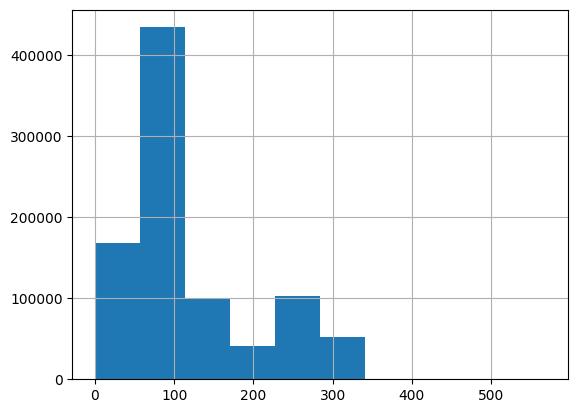

In [17]:
original_dataset['Term'].hist()

La cantidad de tiempo que tenga un deudor para pagar un préstamo, sumado a otros factores, puede ser crucial para la predicción en el problema. Además, la podemos cambiar a días o años si consideráramos.

- **continua**
- **evaluable para correlación**

#### NoEmp

Variable que considera el número de empleados en la empresa, almacenado en un `int`.

<Axes: >

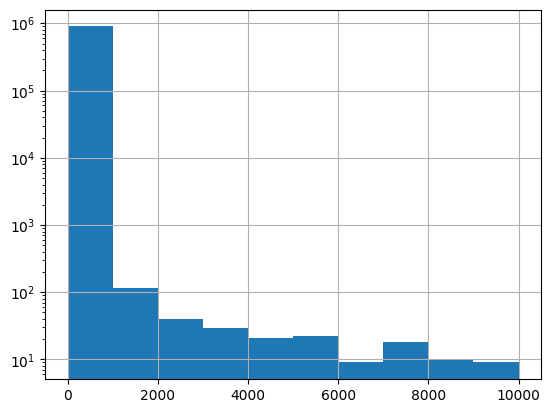

In [18]:
original_dataset['NoEmp'].hist(log=True)

A más empleados, más compleja es la gestión de una empresa, lo cual podemos suponer que podría llegar a afectar con los préstamos.

- **continua**
- **evaluable para correlación**

#### NewExist

Variable que indica si el negocio que pide el préstamo ya existía con más de dos años de antigüedad o si es un negocio creado recientemente (menor o igual a dos años).

- `1` $\rightarrow$ negocio que ya existía
- `2` $\rightarrow$ negocio nuevo

In [19]:
original_dataset['NewExist'].value_counts()

NewExist
1.0    644869
2.0    253125
0.0      1034
Name: count, dtype: int64

Vemos la aparición del valor `0`. Estos son datos erróneos. Será necesario preprocesar los datos si se considera esta variable.

La veteranía de una empresa puede influir en la gestión del pago de sus deudas. Se considera para evaluación.

- **categórica**
- **evaluable para correlación**

#### CreateJob

Número de puestos de trabajo creados, almacenado en un `int`.

<Axes: >

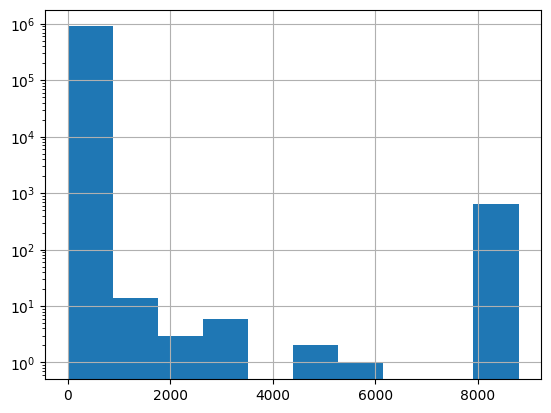

In [20]:
original_dataset['CreateJob'].hist(log=True)

Variable numérica que puede afectar al pago del préstamo como gasto inicial en fuerza social esperado.

- **continua**
- **evaluable para correlación**

#### RetainedJob

Número de puestos de trabajo que se conservan en el tiempo tras la creación. El crecimiento de la empresa medido en trabajadores, almacenado en un `int`.

<Axes: >

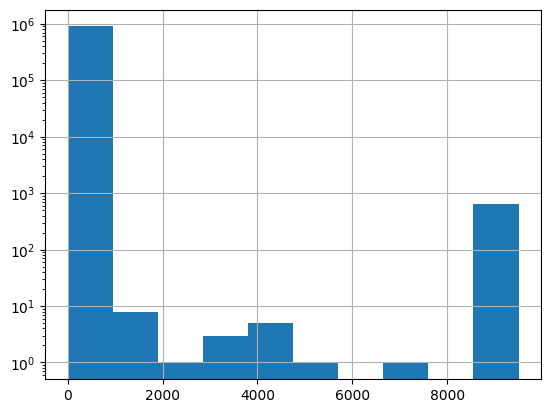

In [21]:
original_dataset['RetainedJob'].hist(log=True)

Está asociado con la variable anterior, así podemos considerarla igualmente para evaluación. Además, podemos asociar y simplificarla con la anterior tal que su relación indique el crecimiento que ha tenido la empresa.

- **continua**
- **evaluable para correlación**

#### FranchiseCode

Código de mínimo cinco dígitos que hace referencia a la franquicia a la que pertenece el negocio (en caso de que forme parte de una franquicia). Cabe destacar que hay dos códigos especiales:

- `"00000"` y `"00001"` $\rightarrow$ Negocio sin franquicia

<Axes: >

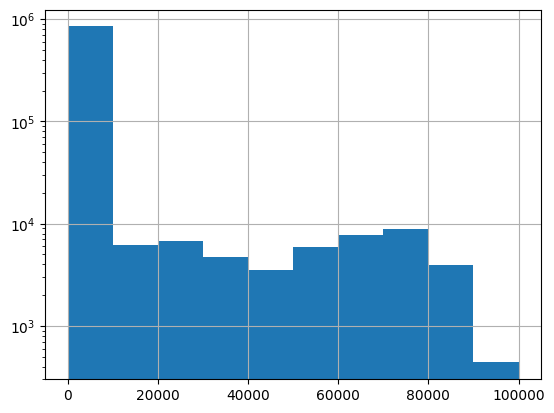

In [22]:
original_dataset['FranchiseCode'].hist(log=True)

Esta es una variable categórica muy dispersa sin interés evaluable dado el número de categorías. Sin embargo puede interesar observar la relación de pertenencia a negocios mayores y la naturaleza de los préstamos y el proceso de pago.

Algo que podremos hacer para simplificar la variable y hacer que sea evaluable es reclasificar todo el dataset en dos categorías:

- Pertenece a una franquicia.
- No pertenece a una franquicia.

Perdemos información por el camino, pero no dejamos de considerar para evaluarla para correlación.

- **categórica**
- **evaluable para evaluación**

#### UrbanRural

Variable `int` que indica la consideración dada al deudor si proviene de un entorno urbano o rural.

In [23]:
original_dataset['UrbanRural'].value_counts()

UrbanRural
1    470654
0    323167
2    105343
Name: count, dtype: int64

El significado de las categorías son:

- `0` $\rightarrow$ indeterminado
- `1` $\rightarrow$ urbano
- `2` $\rightarrow$ rural

Dado que no queremos evaluar ciudades en particular, esta clasificación puede compensar la pérdida de información sumada con la variable `State`. Sin embargo, tener una clase indeterminada puede acabar haciéndola inútil en la correlación.

- **categórica**
- **evaluable para correlación**

#### RevLineCr

Por simplificar, una línea de crédito revolvente es un tipo especial de préstamo que sigue unas normas concretas. Esta variable `str` indica si el préstamo es de este tipo. Los valores posibles son:

- `Y` (yes)
- `N` (no)

In [24]:
original_dataset['RevLineCr'].value_counts()

RevLineCr
N    420288
0    257602
Y    201397
T     15284
1        23
R        14
`        11
2         6
C         2
3         1
,         1
7         1
A         1
5         1
.         1
4         1
-         1
Q         1
Name: count, dtype: int64

Observamos muchos valores ajenos a la clasificación esperada. Estos son considerados como erratas y tendrán que ser procesados, ya que carecemos de una interpretación fehaciente de lo que significan.

Por lo demás, se divide en dataset en dos categorías importantes, por lo que podemos considerar para la evaluación.

- **categórica**
- **evaluable para correlación**

#### LowDoc

_LowDoc Loan_ es otro tipo especial de préstamos considerados en el dataset. Al igual que la variable anterior, los valores posibles son:

- `Y` (yes)
- `N` (no)

In [25]:
original_dataset['LowDoc'].value_counts()

LowDoc
N    782822
Y    110335
0      1491
C       758
S       603
A       497
R        75
1         1
Name: count, dtype: int64

Observamos muchos valores ajenos a la clasificación esperada. Estos son considerados como erratas y tendrán que ser procesados, ya que carecemos de una interpretación feaciente de lo que significan.

Por lo demás, divide en dataset en dos categorías importantes, por lo que podemos considerar para la evaluación.

- **categórica**
- **evaluable para correlación**

#### ChgOffDate

Variable que indica la fecha en la que el préstamo ha caído en impago.

Puede resultar interesante por `ApprovalDate` y `Term` ya que podemos intentar extraer métricas de hasta cuánto tiempo aguantan los deudores pagando.

- **continua**
- **(no) evaluable para correlación**

#### DisbursementDate

Fecha en la que el deudor recibe el desembolso de los fondos del préstamo, almacenado en un `str`.


In [26]:
original_dataset['DisbursementDate'].value_counts()

DisbursementDate
31-Jul-95    10371
30-Apr-95    10320
31-Jan-95     9745
31-Oct-94     8890
31-Oct-95     8161
             ...  
30-Jul-14        1
7-Mar-01         1
6-Jul-01         1
10-Feb-01        1
25-Oct-97        1
Name: count, Length: 8472, dtype: int64

Hay muchas fechas, no lo suficiente como para interpretarlo de manera continua como una línea temporal, y demasiadas para clasificarlas categóricamente.

En este punto, nos damos cuenta que hace una diferenciación entre el día cuando se aprueba el préstamo y cuando se recibe el dinero. Consideramos la opción de fusionar `ApprovalDate` y `DisburmentDate` en una única variable que mida la diferencia entre ambas fechas, pues la inmediatez o retraso en recibir el dinero puede afectar en la gestión del pago del préstamo. No tenemos claro la utilidad, pero así evitamos descartar la información temporal de golpe.

- **continua**
- **(no) evaluable**

#### DisbursementGross

Cantidad de dinero en dólares estadounidenses desembolsados. Al ser una divisa asumimos que el dato estará en `float`.

In [27]:
original_dataset['DisbursementGross'].value_counts()

DisbursementGross
$50,000.00        43787
$100,000.00       36714
$25,000.00        27387
$150,000.00       23373
$10,000.00        21328
                  ...  
$143,118.00           1
$23,827.00            1
$157,338.00           1
$60,698.00            1
$1,086,300.00         1
Name: count, Length: 118859, dtype: int64

In [28]:
original_dataset['DisbursementGross'].dtype

dtype('O')

Hay un inconveniente con la variable: el dato de la divisa va precedido con el símbolo de la divisa. Esto dificulta la conversión de tipos y el símbolo para todo elemento ha de ser eliminado.

La cantidad desembolsada de un préstamo creemos que resulta influyente con respecto a otros factores, por ello la consideraremos para estudio en la correlación.

- **continua**
- **evaluable para correlación**

#### BalanceGross

Indica el importe bruto que falta por pagar en dólares estadounidenses cuando se ha producido el impago.

In [29]:
original_dataset['BalanceGross'].value_counts()

BalanceGross
$0.00           899150
$12,750.00           1
$827,875.00          1
$25,000.00           1
$37,100.00           1
$43,127.00           1
$84,617.00           1
$1,760.00            1
$115,820.00          1
$996,262.00          1
$395,476.00          1
$41,509.00           1
$600.00              1
$9,111.00            1
$96,908.00           1
Name: count, dtype: int64

Hay un inconveniente con la variable: el dato de la divisa va precedido con el símbolo de la divisa. Esto dificulta la conversión de tipos y el símbolo para todo elemento ha de ser eliminado.

Esta variable sólo afecta después de la clasificación en pago o impago, lo que hace que sea inútil para nuestro estudio.

- **continua**
- **no evaluable**

#### ChgOffPrinGr

Variable que representa dinero de la deuda pendiente que se espera que _no_ se consiga pagar

In [30]:
original_dataset['ChgOffPrinGr'].value_counts()

ChgOffPrinGr
$0.00           737152
$50,000.00        2110
$10,000.00        1865
$25,000.00        1371
$35,000.00        1345
                 ...  
$29,982.00           1
$568,599.00          1
$142,721.00          1
$893,162.00          1
$124,847.00          1
Name: count, Length: 83165, dtype: int64

Hay un inconveniente con la variable: el dato de la divisa va precedido con el símbolo de la divisa. Esto dificulta la conversión de tipos y el símbolo para todo elemento ha de ser eliminado.

En función de cuánto se descuenta de la deuda, puede afectar al pago del préstamo.

- **continua**
- **evaluable para correlación**

#### GrAppv

Variable que indica la cantidad de dinero que ha concedido el banco respecto al préstamo.

In [31]:
original_dataset['GrAppv'].value_counts()

GrAppv
$50,000.00        69394
$25,000.00        51258
$100,000.00       50977
$10,000.00        38366
$150,000.00       27624
                  ...  
$407,542.00           1
$220,900.00           1
$57,587.00            1
$531,577.00           1
$1,086,300.00         1
Name: count, Length: 22128, dtype: int64

Hay un inconveniente con la variable: el dato de la divisa va precedido con el símbolo de la divisa. Esto dificulta la conversión de tipos y el símbolo para todo elemento ha de ser eliminado.

La variable en sí es informativa, desconocemos cuánto puede informar respecto al objetivo.

- **continua**
- **(no) evaluable para correlación**

#### SBA_Appv

Variable que indica la cantidad garantizada de dinero que ha concedido la SBA respecto al préstamo.

In [32]:
original_dataset['SBA_Appv'].value_counts()

SBA_Appv
$25,000.00      49579
$12,500.00      40147
$5,000.00       31135
$50,000.00      25047
$10,000.00      17009
                ...  
$192,949.00         1
$212,352.00         1
$57,072.00          1
$32,938.00          1
$715,674.00         1
Name: count, Length: 38326, dtype: int64

Hay un inconveniente con la variable: el dato de la divisa va precedido con el símbolo de la divisa. Esto dificulta la conversión de tipos y el símbolo para todo elemento ha de ser eliminado.

La variable en sí es informativa, desconocemos cuánto puede informar respecto al objetivo. Sin embargo, hemos pensado que quizás la relación con la anterior sí pueda ser relevante. Dado que representamos a la SBA, quizás los préstamos sobre los que concedemos más dinero que los bancos son más seguros, o al revés.

- **continua**
- **(no) evaluable para correlación**

## Preprocesado de datos

Descartamos las variables que tenemos garantizado que no usaremos, y eliminamos posibles duplicados

In [33]:
variables_iniciales_descartadas = ['LoanNr_ChkDgt', 'Name', 'City', 'Zip', 'Bank', 'BalanceGross']

In [34]:
original_dataset.drop_duplicates()
original_dataset.reset_index(drop=True, inplace=True)
dataset_preprocesado = original_dataset.copy(deep=True).drop(columns=variables_iniciales_descartadas)

Estudiamos las cantidad de valores nulos que hay por variable en el dataset

In [35]:
dataset_preprocesado.isnull().sum()

State                    14
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

Destacamos que la variable `ChgOffDate` contiene datos nulos para un porcentaje muy alto del conjunto de datos. Esto hace que la variable sea inoperable y la tengamos que descartar, puesto que considerarla nos haría quedarnos sin dataset.

Esto se debe a que la varaible solo tiene valores para aquellos préstamos que han caído en impago. Considerarla haría que solo trabajásemos con los valores de una de las clases a clasificar.

In [36]:
dataset_preprocesado = dataset_preprocesado.drop(columns=['ChgOffDate'])

Ahora eliminamos los elementos con valores nulos en alguna de sus columnas:

In [37]:
dataset_preprocesado = dataset_preprocesado.dropna()
valores_nulos = tamPoblacional - dataset_preprocesado.shape[0]
print('Eliminados:', valores_nulos)
dataset_preprocesado.isnull().sum()

Eliminados: 12882


State                0
BankState            0
NAICS                0
ApprovalDate         0
ApprovalFY           0
Term                 0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementDate     0
DisbursementGross    0
MIS_Status           0
ChgOffPrinGr         0
GrAppv               0
SBA_Appv             0
dtype: int64

In [38]:
dataset_preprocesado.reset_index(drop=True, inplace=True)

In [39]:
tamPoblacionalSinNulos = dataset_preprocesado.shape[0]
numVariablesSinNulos = dataset_preprocesado.shape[1]

print(f"-- Naturaleza del conjunto de datos preprocesado --")
print(f"Número de elementos en la muestra: {tamPoblacionalSinNulos} ({(-1 + (tamPoblacionalSinNulos/tamPoblacional)):.2%})")
print(f"Número de variables en la muestra: {numVariablesSinNulos}")

-- Naturaleza del conjunto de datos preprocesado --
Número de elementos en la muestra: 886282 (-1.43%)
Número de variables en la muestra: 20


### Formateo de variables

#### Variables con divisa
Adaptamos `DisbursementGross`, `ChgOffPrinGr`, `GrAppv` y `SBA_Appv` para que se detecten como floats. Para ello, tendremos que borrar el "$" y las ",". Para ello, construimos una función de reemplazo de caracteres en una cadena:

In [40]:
def currency_formatter(x) -> str :
    """
    Formatea un número como una cadena de texto sin el símbolo de dólar ni separadores de miles.
    """
    return x.strip().replace('$', '').replace(',', '')

Y la aplicamos cómodamente con un map a cada varaible, convirtiendo los datos a `float`:

In [41]:
dataset_preprocesado[['DisbursementGross', 'GrAppv', 'SBA_Appv', 'ChgOffPrinGr']] = dataset_preprocesado[['DisbursementGross', 'GrAppv', 'SBA_Appv', 'ChgOffPrinGr']].applymap(currency_formatter).astype(float)
dataset_preprocesado[['DisbursementGross', 'GrAppv', 'SBA_Appv', 'ChgOffPrinGr']].head(4)

/var/folders/dn/z802f2_d7g73lkp9775vjs740000gn/T/ipykernel_36524/3814859698.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataset_preprocesado[['DisbursementGross', 'GrAppv', 'SBA_Appv', 'ChgOffPrinGr']] = dataset_preprocesado[['DisbursementGross', 'GrAppv', 'SBA_Appv', 'ChgOffPrinGr']].applymap(currency_formatter).astype(float)


DisbursementGross    GrAppv  SBA_Appv  ChgOffPrinGr
0            60000.0   60000.0   48000.0           0.0
1            40000.0   40000.0   32000.0           0.0
2           287000.0  287000.0  215250.0           0.0
3            35000.0   35000.0   28000.0           0.0

#### Código NAICS a industria
Adaptamos los códigos NAICS para solo quedarnos con los dos primeros dígitos y pasarlo a su etiqueta correspondiente:

In [42]:
dataset_preprocesado['NAICS'] = dataset_preprocesado['NAICS'].astype(str).str[:2]
dataset_preprocesado['NAICS'] = dataset_preprocesado['NAICS'].map(abreviaturas_tipos_industria)
dataset_preprocesado['NAICS'].value_counts(dropna=False)

NAICS
NaN             198298
Minorista       125763
Otros            71756
Manufactura      67110
Turismo          67084
STEM             66954
Construccion     65636
Salud            54633
Mayorista        48150
Residuos         32114
Logistica        22136
Artes            14460
Inmuebles        13457
Info             11220
Seguros           9378
ASPC              8868
Educacion         6313
MCE               1820
SP                 654
Gestion            256
AP                 222
Name: count, dtype: int64

#### Term conversión a años
Esta variable está medida en meses, pero pensamos que sería más cómoda medirla en años

In [43]:
dataset_preprocesado['Term'] = dataset_preprocesado['Term'].map(lambda x: x / 12)
dataset_preprocesado['Term'].head(4)

0     7.0
1     5.0
2    15.0
3     5.0
Name: Term, dtype: float64

#### Corrección de NewExist
Convertimos los valores tal que:

- `0` pasa a ser `NaN`
- `1` pasa a 'Existing'
- `2` pasa a 'New'

In [44]:
dataset_preprocesado['NewExist'] = dataset_preprocesado['NewExist'].map({1 : 'Existing', 2 : 'New'})
dataset_preprocesado['NewExist'].value_counts(dropna=False)

NewExist
Existing    636166
New         249095
NaN           1021
Name: count, dtype: int64

#### Adaptación de FranchiseCode
Aprovechamos y adaptamos los códigos de franquicia a valor 1 y en caso contrario a 0, en una nueva variable llamada 'Franchise'

In [45]:
dataset_preprocesado.loc[(dataset_preprocesado['FranchiseCode'] <= 1), 'Franchise'] = 0
dataset_preprocesado.loc[(dataset_preprocesado['FranchiseCode'] > 1), 'Franchise'] = 1

dataset_preprocesado['Franchise'].value_counts(dropna=False)

Franchise
0.0    835078
1.0     51204
Name: count, dtype: int64

#### Corrección de RevLineCr
Eliminamos los valores erróneos y nos quedamos con los sies y nos.

In [46]:
dataset_preprocesado['RevLineCr'] = dataset_preprocesado['RevLineCr'].map({'Y' : 'Y', 'N' : 'N'})
dataset_preprocesado['RevLineCr'].value_counts(dropna=False)

RevLineCr
N      415473
NaN    272539
Y      198270
Name: count, dtype: int64

#### Corrección de LowDoc
Eliminamos los valores erróneos y nos quedamos con los sies y nos.

In [47]:
dataset_preprocesado['LowDoc'] = dataset_preprocesado['LowDoc'].map({'Y' : 'Y', 'N' : 'N'})
dataset_preprocesado['LowDoc'].value_counts(dropna=False)

LowDoc
N      775228
Y      107897
NaN      3157
Name: count, dtype: int64

### Derivación de variables

#### Tiempo entre aprobación y desembolso del préstamo
Guardamos la diferencia en días entre ambas fechas, para concentrar ambas variables en una, a la que llamaremos `ApprvToDisbDays`. Transformaremos ambas variables a un tipo fecha y las restamos.

In [48]:
dataset_preprocesado['ApprovalDate'] = pd.to_datetime(dataset_preprocesado['ApprovalDate'], format='%d-%b-%y')
dataset_preprocesado['DisbursementDate'] = pd.to_datetime(dataset_preprocesado['DisbursementDate'], format='%d-%b-%y')

dataset_preprocesado['ApprvToDisbDays'] = (dataset_preprocesado['DisbursementDate'] - dataset_preprocesado['ApprovalDate']).dt.days

#### Ratio de empleos retenidos/creados
Medimos la fuerza de crecimiento en número de personal de la empresa con éste índice, concentrando número de empleados, puestos creados y puestos retenidos en una variable.

In [49]:

dataset_preprocesado['GrowthRatio'] = dataset_preprocesado.apply((lambda x: (x['CreateJob'] + x['RetainedJob']) / x['NoEmp'] if x['NoEmp'] > 0 else 0), axis=1)
dataset_preprocesado['GrowthRatio'].value_counts(dropna=False)

GrowthRatio
0.000000    384488
1.000000    277748
2.000000     42630
3.000000     16996
1.500000     16247
             ...  
1.569231         1
1.548387         1
7.555556         1
0.282353         1
0.094203         1
Name: count, Length: 3592, dtype: int64

#### Ratio de apoyo de la SBA en el crédito
Medimos si la organización que representamos ha apoyado con más dinero en el préstamo que el banco del deudor, juntando SBA_Appv y GrAppv en una sola, llamada `SBASupportRatio`

In [50]:
dataset_preprocesado['SBASupportRatio'] = (dataset_preprocesado['SBA_Appv'].astype(float) / dataset_preprocesado['GrAppv'].astype(float))
dataset_preprocesado['SBASupportRatio'].value_counts(dropna=False)

SBASupportRatio
0.500000    322559
0.750000    176972
0.850000    119417
0.800000     80468
0.900000     73535
             ...  
0.540488         1
0.520001         1
0.821852         1
0.776006         1
0.698900         1
Name: count, Length: 13998, dtype: int64

### Limpieza del preprocesado

Gracias a juntar y formatear variables, podemos quitar las siguientes variables:

In [51]:
variables_preprocesado_descartadas = ['ApprovalDate', 'DisbursementDate', 'CreateJob', 'RetainedJob', 'NoEmp', 'SBA_Appv', 'GrAppv', 'FranchiseCode']

In [52]:
dataset_preprocesado = dataset_preprocesado.drop(columns=variables_preprocesado_descartadas)
dataset_preprocesado.reset_index(drop=True, inplace=True)

Realizamos un estudio de valores nulos generados en el preprocesado:

In [53]:
dataset_preprocesado.isnull().sum()

State                     0
BankState                 0
NAICS                198298
ApprovalFY                0
Term                      0
NewExist               1021
UrbanRural                0
RevLineCr            272539
LowDoc                 3157
DisbursementGross         0
MIS_Status                0
ChgOffPrinGr              0
Franchise                 0
ApprvToDisbDays           0
GrowthRatio               0
SBASupportRatio           0
dtype: int64

Eliminamos los valores nulos

In [54]:
dataset_analisis = dataset_preprocesado.dropna()
dataset_analisis.reset_index(drop=True, inplace=True)

In [55]:
valores_nulos_preprocesado = dataset_preprocesado.shape[0] - dataset_analisis.shape[0]
print('Eliminados:', valores_nulos_preprocesado)
dataset_analisis.isnull().sum()

Eliminados: 429334


State                0
BankState            0
NAICS                0
ApprovalFY           0
Term                 0
NewExist             0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementGross    0
MIS_Status           0
ChgOffPrinGr         0
Franchise            0
ApprvToDisbDays      0
GrowthRatio          0
SBASupportRatio      0
dtype: int64

Este sería, a grandes rasgos, el dataset que analizaríamos:

In [56]:
dataset_analisis.info()
dataset_analisis.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456948 entries, 0 to 456947
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   State              456948 non-null  object 
 1   BankState          456948 non-null  object 
 2   NAICS              456948 non-null  object 
 3   ApprovalFY         456948 non-null  object 
 4   Term               456948 non-null  float64
 5   NewExist           456948 non-null  object 
 6   UrbanRural         456948 non-null  int64  
 7   RevLineCr          456948 non-null  object 
 8   LowDoc             456948 non-null  object 
 9   DisbursementGross  456948 non-null  float64
 10  MIS_Status         456948 non-null  object 
 11  ChgOffPrinGr       456948 non-null  float64
 12  Franchise          456948 non-null  float64
 13  ApprvToDisbDays    456948 non-null  int64  
 14  GrowthRatio        456948 non-null  float64
 15  SBASupportRatio    456948 non-null  float64
dtypes:

State BankState      NAICS ApprovalFY           Term  NewExist  \
count   456948    456948     456948     456948  456948.000000    456948   
unique      51        54         20         29            NaN         2   
top         CA        NC  Minorista       2007            NaN  Existing   
freq     61387     56407      80953      57028            NaN    335829   
mean       NaN       NaN        NaN        NaN       7.817565       NaN   
std        NaN       NaN        NaN        NaN       5.696851       NaN   
min        NaN       NaN        NaN        NaN       0.000000       NaN   
25%        NaN       NaN        NaN        NaN       4.916667       NaN   
50%        NaN       NaN        NaN        NaN       7.000000       NaN   
75%        NaN       NaN        NaN        NaN       7.500000       NaN   
max        NaN       NaN        NaN        NaN      43.916667       NaN   

           UrbanRural RevLineCr  LowDoc  DisbursementGross MIS_Status  \
count   456948.000000    456948  456948       4.569480e+05     456948   
unique            NaN         2       2                NaN          2   
top               NaN         N       N                NaN      P I F   
freq              NaN    265007  431845                NaN     358565   
mean         0.900588       NaN     NaN       1.721620e+05        NaN   
std          0.604302       NaN     NaN       2.751142e+05        NaN   
min          0.000000       NaN     NaN       4.000000e+03        NaN   
25%          1.000000       NaN     NaN       3.500000e+04        NaN   
50%          1.000000       NaN     NaN       7.576450e+04        NaN   
75%          1.000000       NaN     NaN       1.920000e+05        NaN   
max          2.000000       NaN     NaN       1.144632e+07        NaN   

        ChgOffPrinGr      Franchise  ApprvToDisbDays    GrowthRatio  \
count   4.569480e+05  456948.000000    456948.000000  456948.000000   
unique           NaN            NaN              NaN            NaN   
top              NaN            NaN              NaN            NaN   
freq             NaN            NaN              NaN            NaN   
mean    1.293325e+04       0.031214       108.579983       1.186468   
std     5.807871e+04       0.173895       190.739939       7.895832   
min     0.000000e+00       0.000000     -3614.000000       0.000000   
25%     0.000000e+00       0.000000        26.000000       0.000000   
50%     0.000000e+00       0.000000        49.000000       1.000000   
75%     0.000000e+00       0.000000       108.000000       1.000000   
max     3.512596e+06       1.000000      9132.000000    4441.000000   

        SBASupportRatio  
count     456948.000000  
unique              NaN  
top                 NaN  
freq                NaN  
mean           0.652473  
std            0.179334  
min            0.050000  
25%            0.500000  
50%            0.500000  
75%            0.819209  
max            1.000000

## Análisis de las variables continuas
Las variables numéricas finales son:

In [57]:
variables_numericas_analisis = ['Term', 'DisbursementGross', 'ChgOffPrinGr', 'ApprvToDisbDays', 'SBASupportRatio', 'GrowthRatio']
analisis_numerico = dataset_analisis.loc[:, variables_numericas_analisis]

In [58]:
analisis_numerico.describe(include='all')

Term  DisbursementGross  ChgOffPrinGr  ApprvToDisbDays  \
count  456948.000000       4.569480e+05  4.569480e+05    456948.000000   
mean        7.817565       1.721620e+05  1.293325e+04       108.579983   
std         5.696851       2.751142e+05  5.807871e+04       190.739939   
min         0.000000       4.000000e+03  0.000000e+00     -3614.000000   
25%         4.916667       3.500000e+04  0.000000e+00        26.000000   
50%         7.000000       7.576450e+04  0.000000e+00        49.000000   
75%         7.500000       1.920000e+05  0.000000e+00       108.000000   
max        43.916667       1.144632e+07  3.512596e+06      9132.000000   

       SBASupportRatio    GrowthRatio  
count    456948.000000  456948.000000  
mean          0.652473       1.186468  
std           0.179334       7.895832  
min           0.050000       0.000000  
25%           0.500000       0.000000  
50%           0.500000       1.000000  
75%           0.819209       1.000000  
max           1.000000    4441.000000

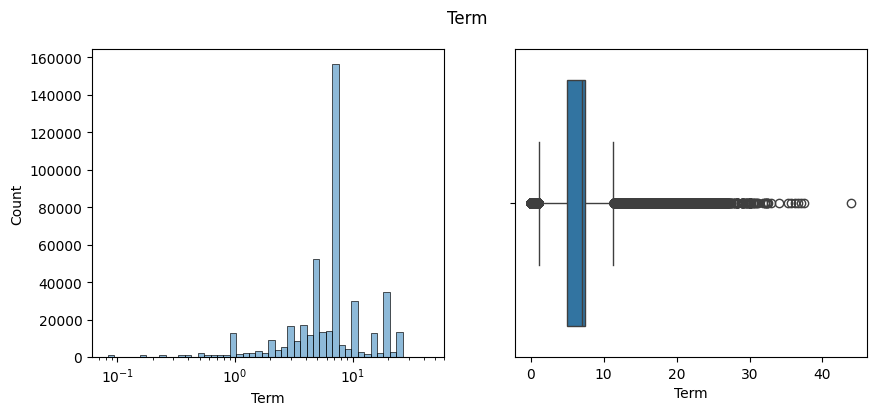

<Figure size 640x480 with 0 Axes>

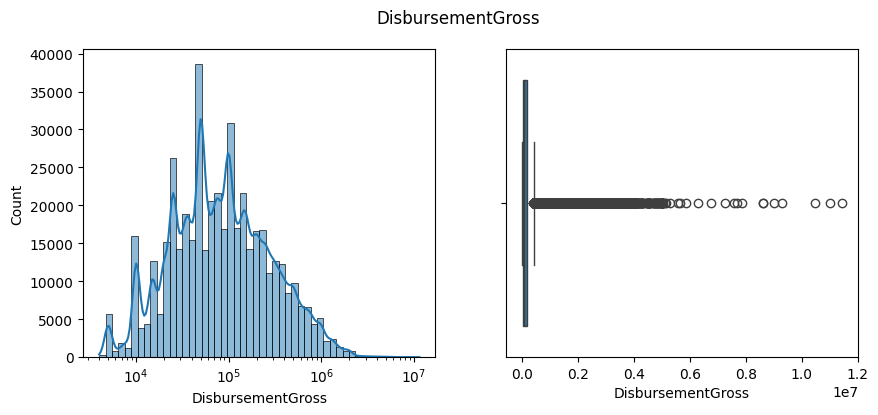

<Figure size 640x480 with 0 Axes>

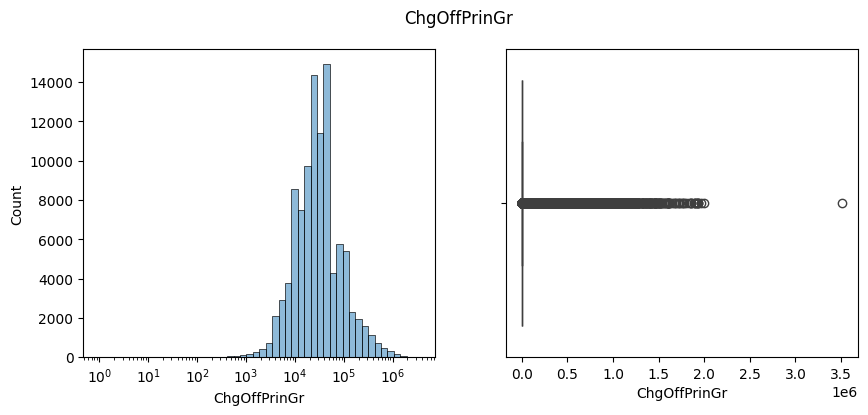

<Figure size 640x480 with 0 Axes>

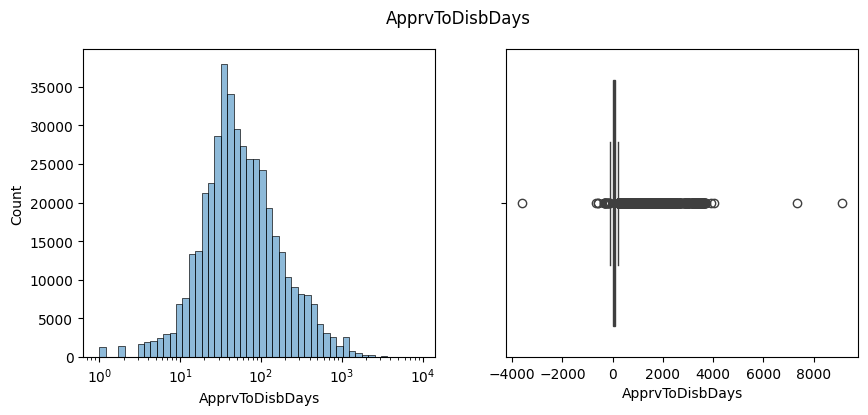

<Figure size 640x480 with 0 Axes>

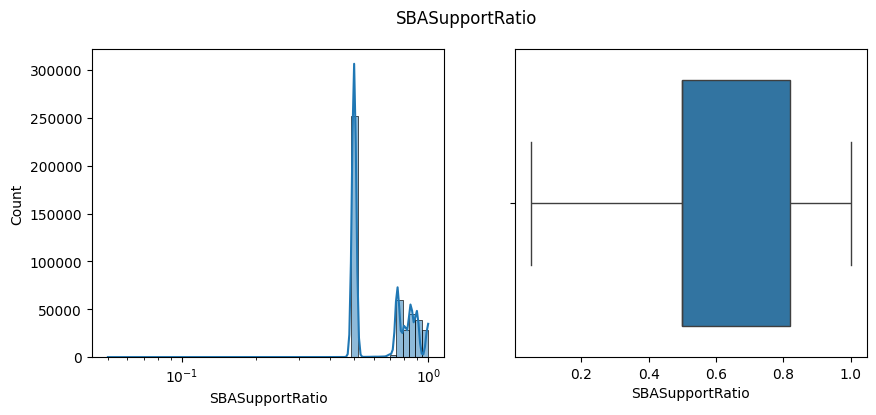

<Figure size 640x480 with 0 Axes>

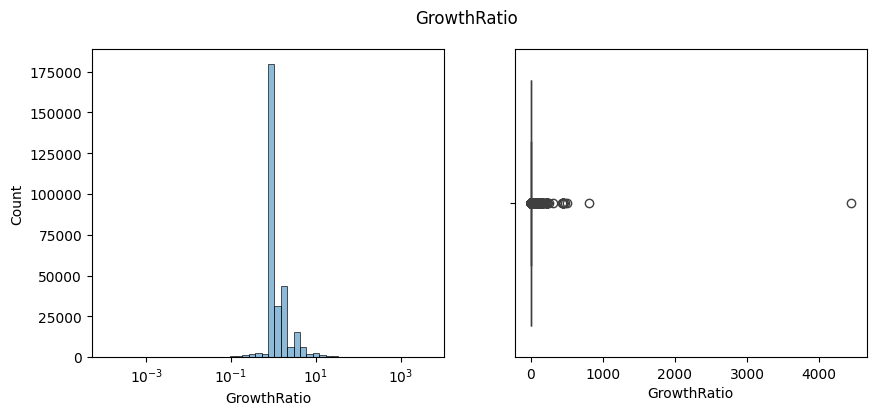

<Figure size 640x480 with 0 Axes>

In [59]:
# Dibujamos los histogramas y los diagramas de caja de las variables numéricas para contextualizarlas
for var in variables_numericas_analisis:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(data=analisis_numerico, x=var, kde=True, ax=ax[0], legend=True, log_scale=True, bins=50)
    sns.boxplot(data=analisis_numerico, x=var, ax=ax[1])
    plt.suptitle(var)
    plt.show()
    plt.savefig(IMAGES_PATH + 'continuas/' + var + '.png')
    plt.close(fig)

Explicacion

## Análisis de las varaibles categóricas.

Las variables categóricas son:

In [60]:
variables_categoricas_analisis = ['NAICS', 'UrbanRural', 'NewExist', 'Franchise', 'RevLineCr', 'LowDoc', 'MIS_Status', 'ApprovalFY', 'State', 'BankState']
analisis_categorico = dataset_analisis.loc[:, variables_categoricas_analisis]

In [61]:
analisis_categorico.describe(include='all')

NAICS     UrbanRural  NewExist      Franchise RevLineCr  LowDoc  \
count      456948  456948.000000    456948  456948.000000    456948  456948   
unique         20            NaN         2            NaN         2       2   
top     Minorista            NaN  Existing            NaN         N       N   
freq        80953            NaN    335829            NaN    265007  431845   
mean          NaN       0.900588       NaN       0.031214       NaN     NaN   
std           NaN       0.604302       NaN       0.173895       NaN     NaN   
min           NaN       0.000000       NaN       0.000000       NaN     NaN   
25%           NaN       1.000000       NaN       0.000000       NaN     NaN   
50%           NaN       1.000000       NaN       0.000000       NaN     NaN   
75%           NaN       1.000000       NaN       0.000000       NaN     NaN   
max           NaN       2.000000       NaN       1.000000       NaN     NaN   

       MIS_Status ApprovalFY   State BankState  
count      456948     456948  456948    456948  
unique          2         29      51        54  
top         P I F       2007      CA        NC  
freq       358565      57028   61387     56407  
mean          NaN        NaN     NaN       NaN  
std           NaN        NaN     NaN       NaN  
min           NaN        NaN     NaN       NaN  
25%           NaN        NaN     NaN       NaN  
50%           NaN        NaN     NaN       NaN  
75%           NaN        NaN     NaN       NaN  
max           NaN        NaN     NaN       NaN

In [62]:
# Creamos un DataFrame para almacenar las estadísticas de las variables categoricas. Simulamos el describe de las variables categóricas
df_stats_categorical = pd.DataFrame(columns=['Count', 'Unique', 'Top', 'Freq'], index=variables_categoricas_analisis)

# Extraemos del describe de las variables categóricas numerizadas el conteo de valores, para ahorrar el cálculo
describe_categorical = analisis_categorico.describe()
aux = df_stats_categorical['Count'].apply(lambda x : 456948 if True else 456948)
df_stats_categorical['Count'] = aux

# Extraemos el resto de estadísticas
for var in variables_categoricas_analisis:
    
    # Extraemos  los distintos valores y sus frecuencias
    typeValueCounts = dataset_analisis[var].value_counts()
    # La longitud de la lista de etiquetas es el número de valores únicos
    df_stats_categorical.loc[var,'Unique'] = typeValueCounts.index.size
    # Extraemos el valor más frecuente y su frecuencia y lo almacenamos en el DataFrame
    maximumLabel, maximumValue = typeValueCounts.idxmax(), typeValueCounts.max()
    df_stats_categorical.loc[var,'Top'] = maximumLabel
    df_stats_categorical.loc[var,'Freq'] = maximumValue

df_stats_categorical

Count Unique        Top    Freq
NAICS       456948     20  Minorista   80953
UrbanRural  456948      3          1  285564
NewExist    456948      2   Existing  335829
Franchise   456948      2        0.0  442685
RevLineCr   456948      2          N  265007
LowDoc      456948      2          N  431845
MIS_Status  456948      2      P I F  358565
ApprovalFY  456948     29       2007   57028
State       456948     51         CA   61387
BankState   456948     54         NC   56407

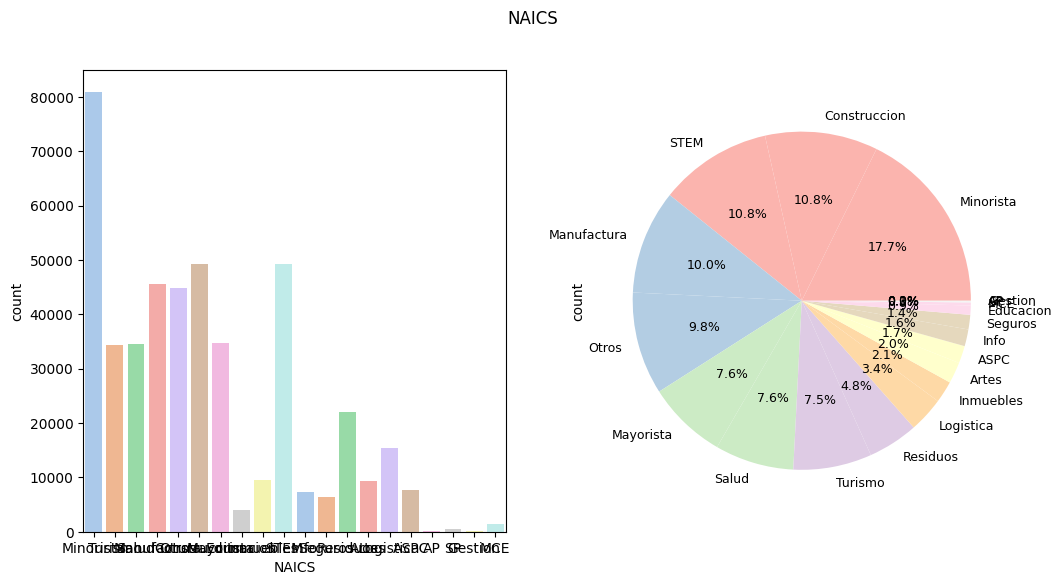

<Figure size 640x480 with 0 Axes>

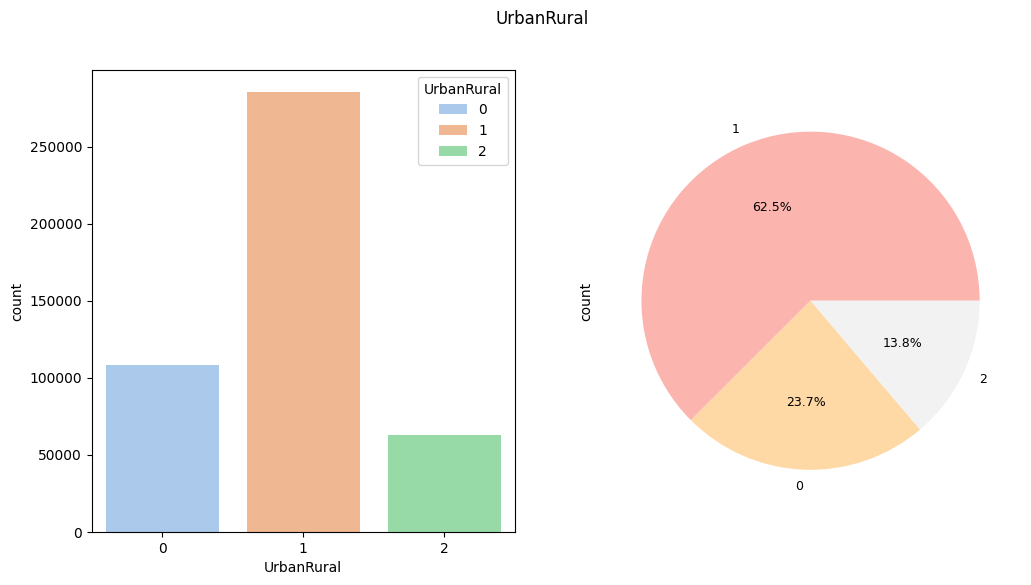

<Figure size 640x480 with 0 Axes>

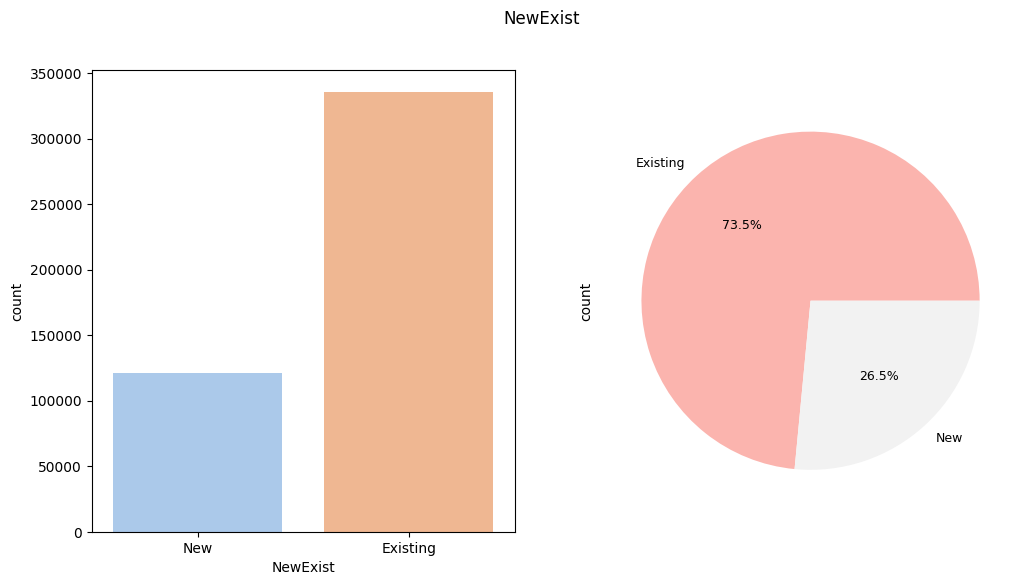

<Figure size 640x480 with 0 Axes>

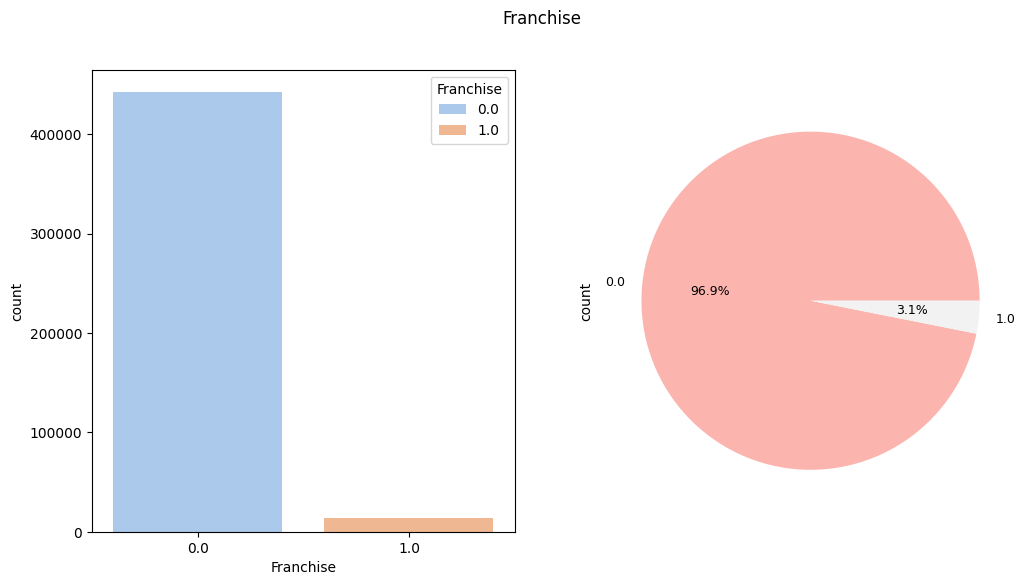

<Figure size 640x480 with 0 Axes>

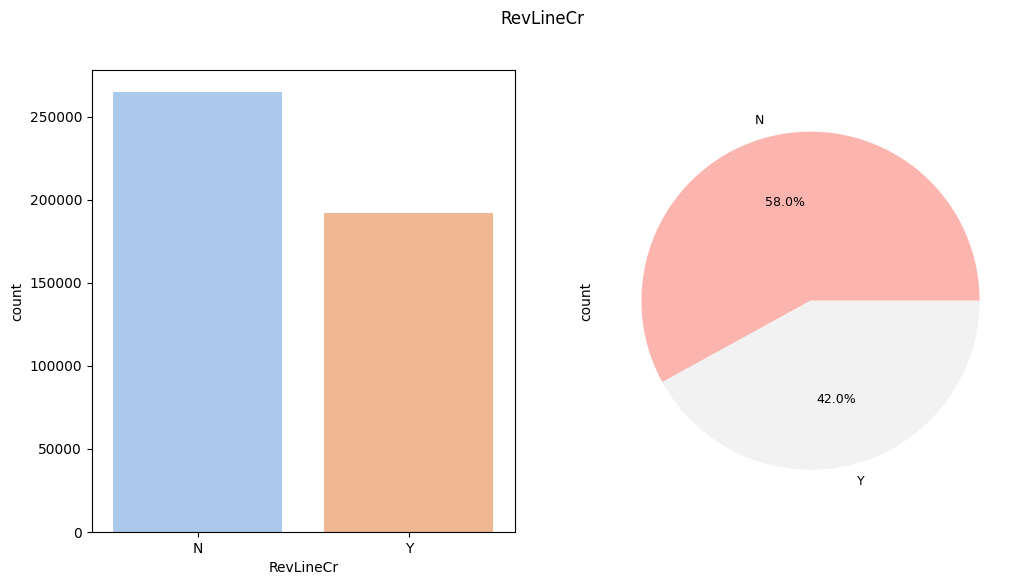

<Figure size 640x480 with 0 Axes>

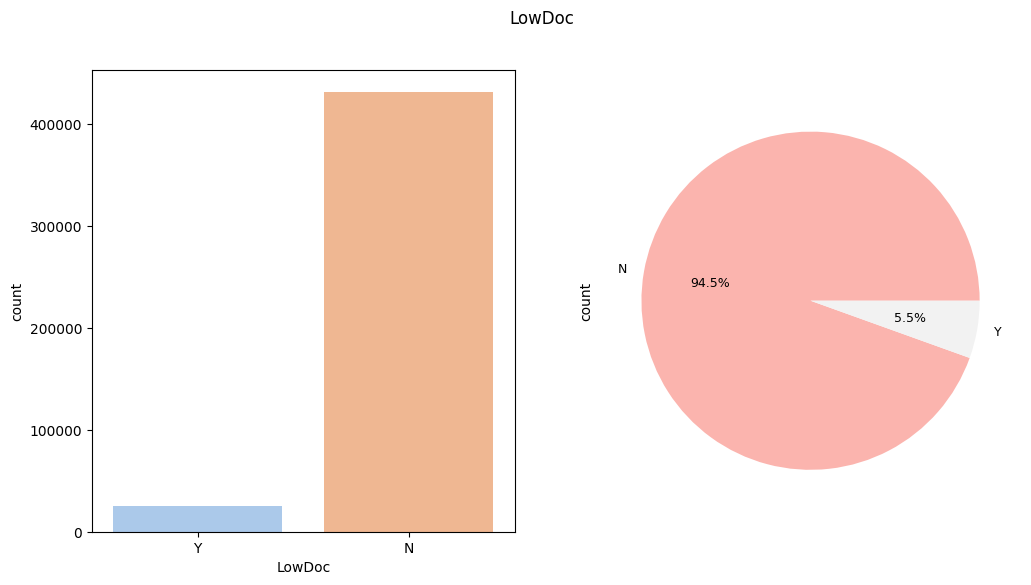

<Figure size 640x480 with 0 Axes>

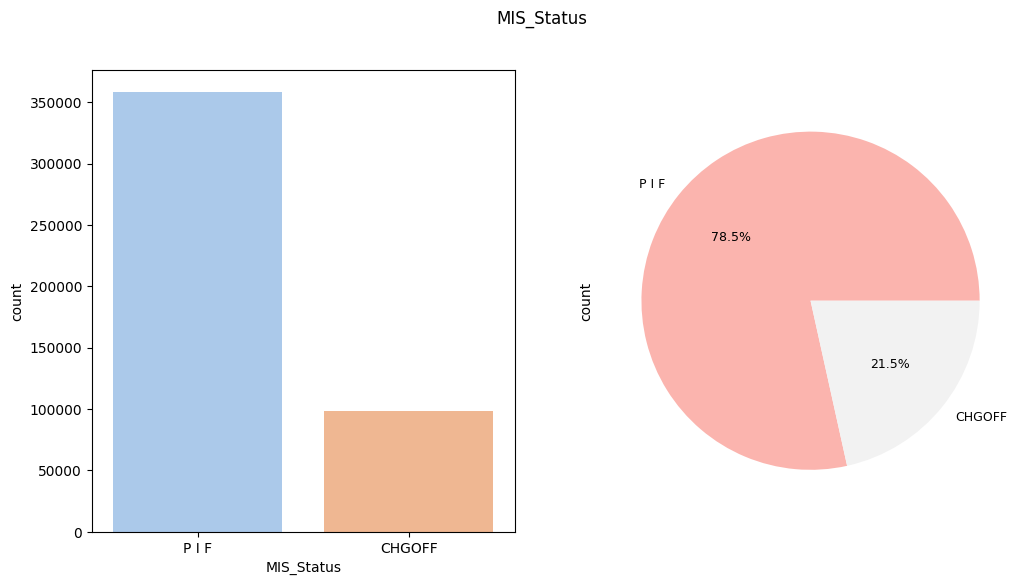

<Figure size 640x480 with 0 Axes>

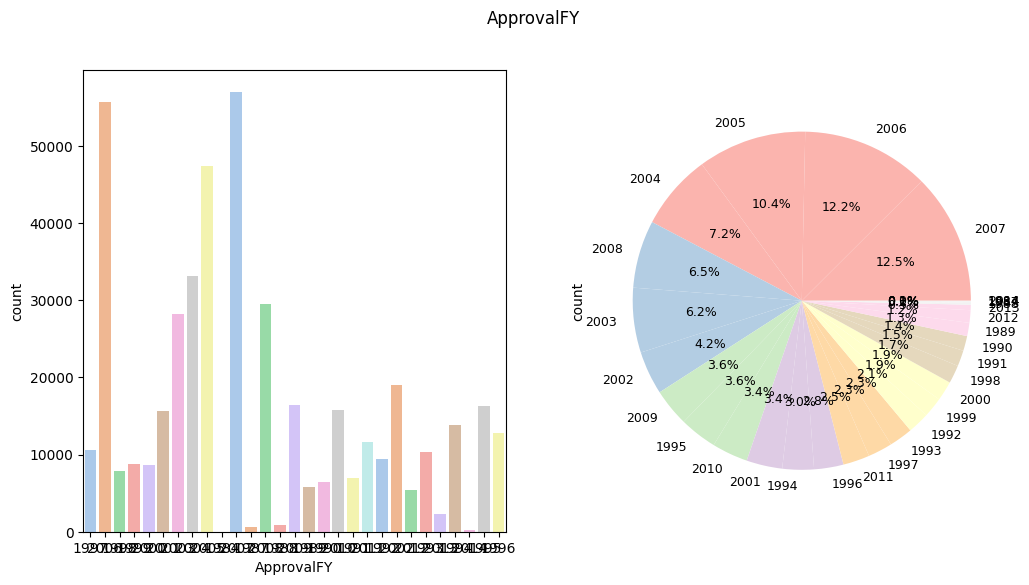

<Figure size 640x480 with 0 Axes>

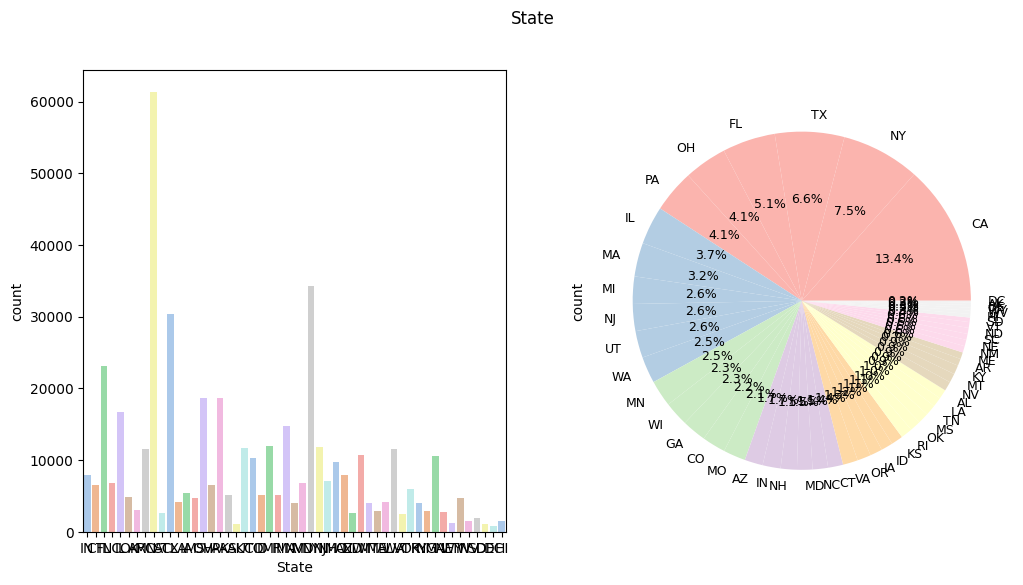

<Figure size 640x480 with 0 Axes>

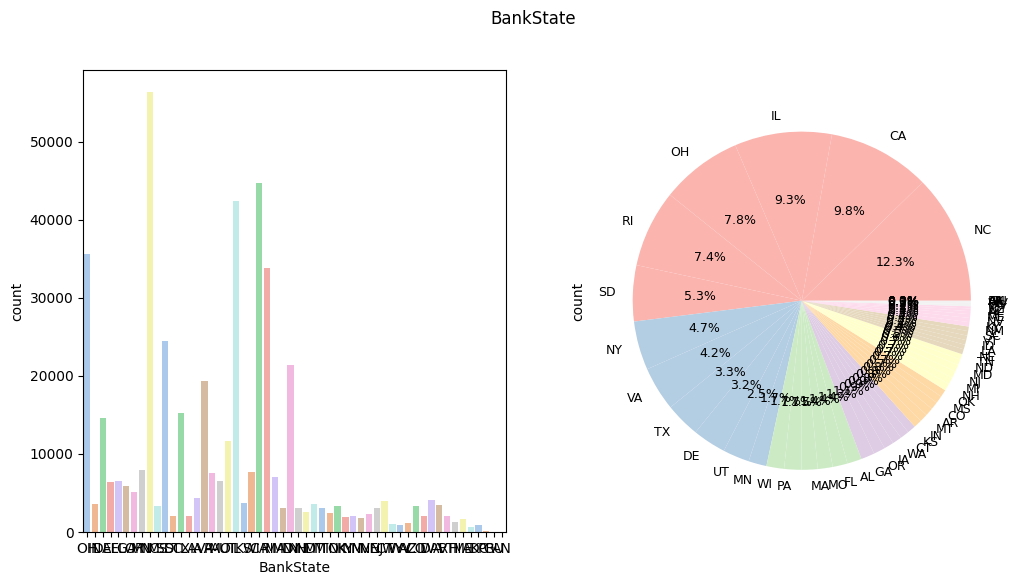

<Figure size 640x480 with 0 Axes>

In [63]:
# Dibujamos los histogramas y los diagramas de barras y de sectores de las variables numéricas para contextualizarlas
for var in variables_categoricas_analisis:
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    # Diagrama de barras con función de conteo para variables categóricas
    sns.countplot(data=dataset_analisis, x=var, ax=ax[0], hue=var, palette='pastel')
    # Diagrama de sectores
    dataset_analisis[var].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1], cmap='Pastel1', fontsize=9)
    plt.suptitle(var)
    plt.show()
    plt.savefig(IMAGES_PATH + 'categoricas/' + var + '.png')
    plt.close(fig)

### Etiqueta de las variables categóricas
Transformamos los datos categóricos necesarios a numéricos, usando el LabelEncoder. Principalmente por evitar el exceso de variables

In [64]:
variables_etiquetar = ['NAICS', 'NewExist', 'RevLineCr', 'LowDoc', 'MIS_Status', 'ApprovalFY', 'State', 'BankState']

In [65]:
dataset_numerico = dataset_analisis.copy()
labeller = LabelEncoder()
for var in variables_etiquetar:
    dataset_numerico[var] = labeller.fit_transform(dataset_numerico[var])
    print(f"Variable {var} etiquetada. Valores únicos: {dataset_numerico[var].unique()}")

Variable NAICS etiquetada. Valores únicos: [12 19 17 10 13  3 11  4  7 16  6 18 14  2  8  1  0 15  5  9]
Variable NewExist etiquetada. Valores únicos: [1 0]
Variable RevLineCr etiquetada. Valores únicos: [0 1]
Variable LowDoc etiquetada. Valores únicos: [1 0]
Variable MIS_Status etiquetada. Valores únicos: [1 0]
Variable ApprovalFY etiquetada. Valores únicos: [11 20 12 13 14 15 17 18 19  0 21  1 22  2 23  3  4 24  5 25  6 16 26  7
 27  8 28  9 10]
Variable State etiquetada. Valores únicos: [15  6  9 27 14 36  2 23  4 40 43 18 12 25 35 45 38 16  0 44  5 13 22 39
 19 33 20 34 31 30 24  3 28 48 26 21  1 47 46 37 17 32 10 29 50 42 49 41
  8  7 11]
Variable BankState etiquetada. Valores únicos: [37 17  9  1 10 11 39 25 29 27 44 43 46 20 14 48 40 26 47 16 18 51  5 42
 21 22 36 32 30 28 24 45 38 19 34 35 31 33  7 53 52  4  6 15 50  3 49 13
 23  0  8 41 12  2]


## Estudio de correlación entre variables

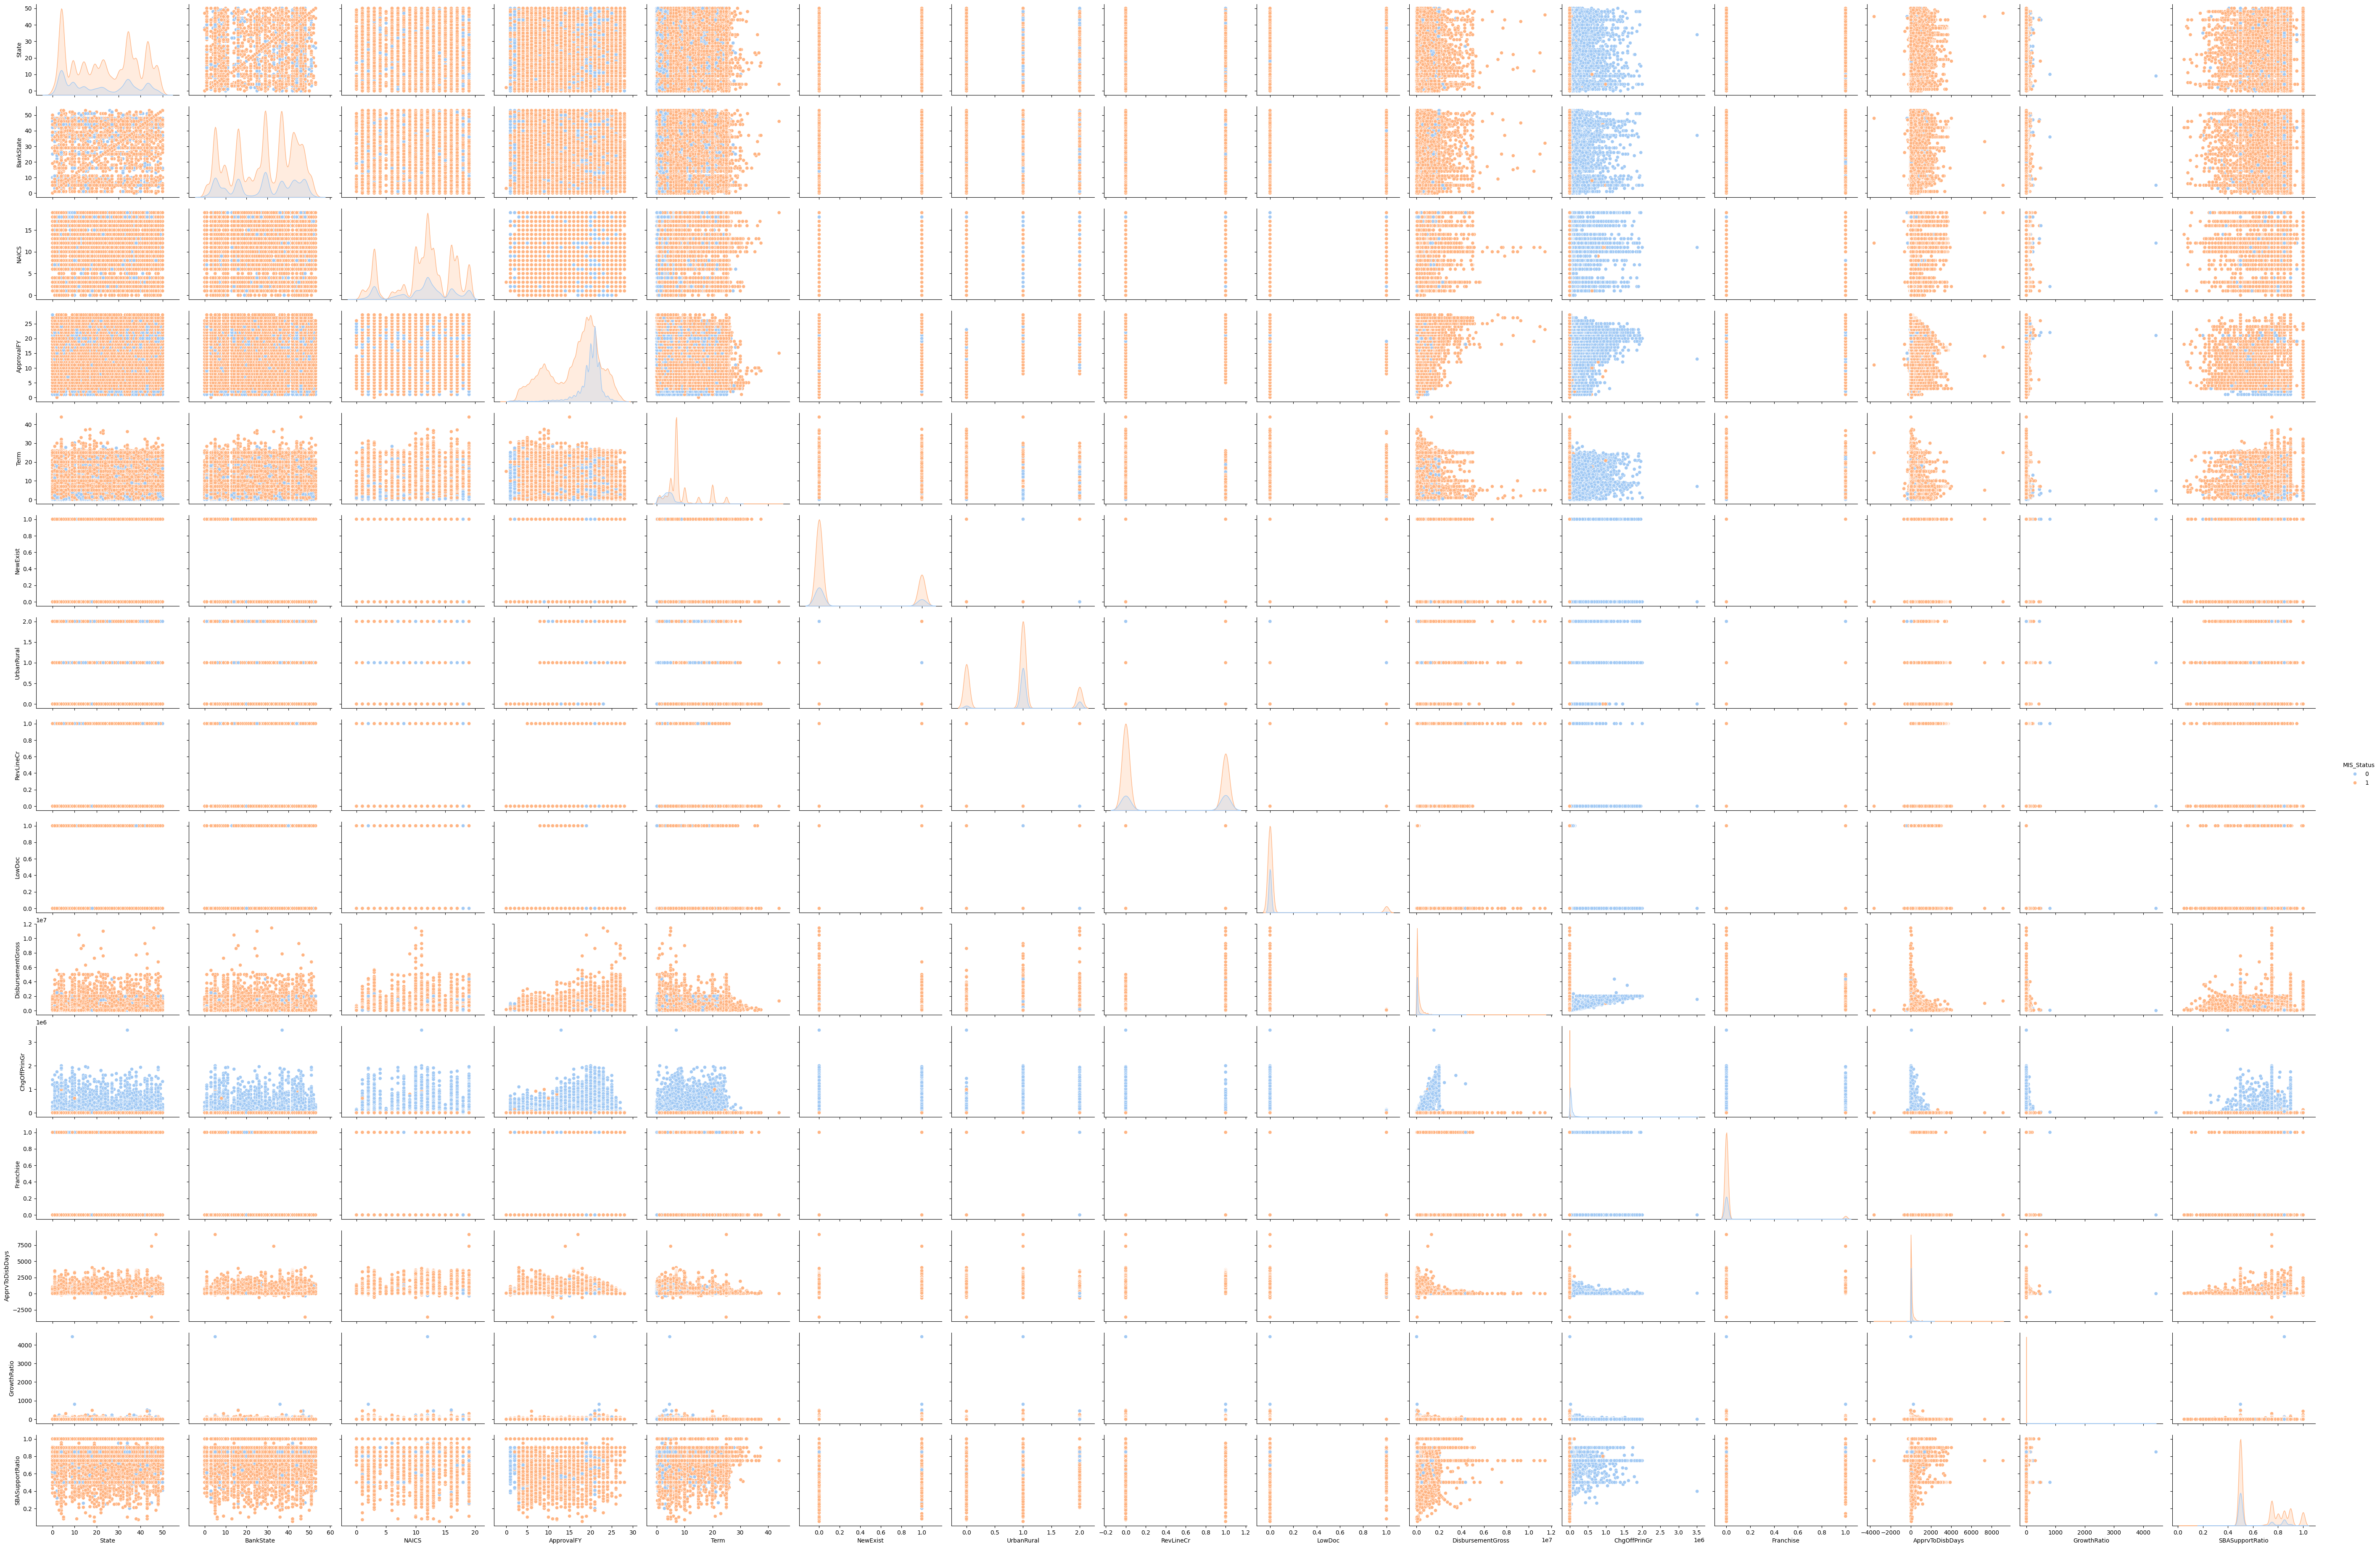

In [66]:
import os
from IPython.display import Image, display

# Comprobar si ya existe la imagen guardada
pairplot_path = IMAGES_PATH + 'pairplot.png'

if os.path.exists(pairplot_path):
    # Mostrar directamente la imagen ya generada
    display(Image(filename=pairplot_path))
else:
    # Generar y guardar el pairplot solo si no existe
    sns.pairplot(dataset_numerico, hue='MIS_Status', diag_kind='kde',
                 palette='pastel', height=2.5, aspect=1.5)
    plt.savefig(pairplot_path)
    plt.close()
    display(Image(filename=pairplot_path))

#128 minutos

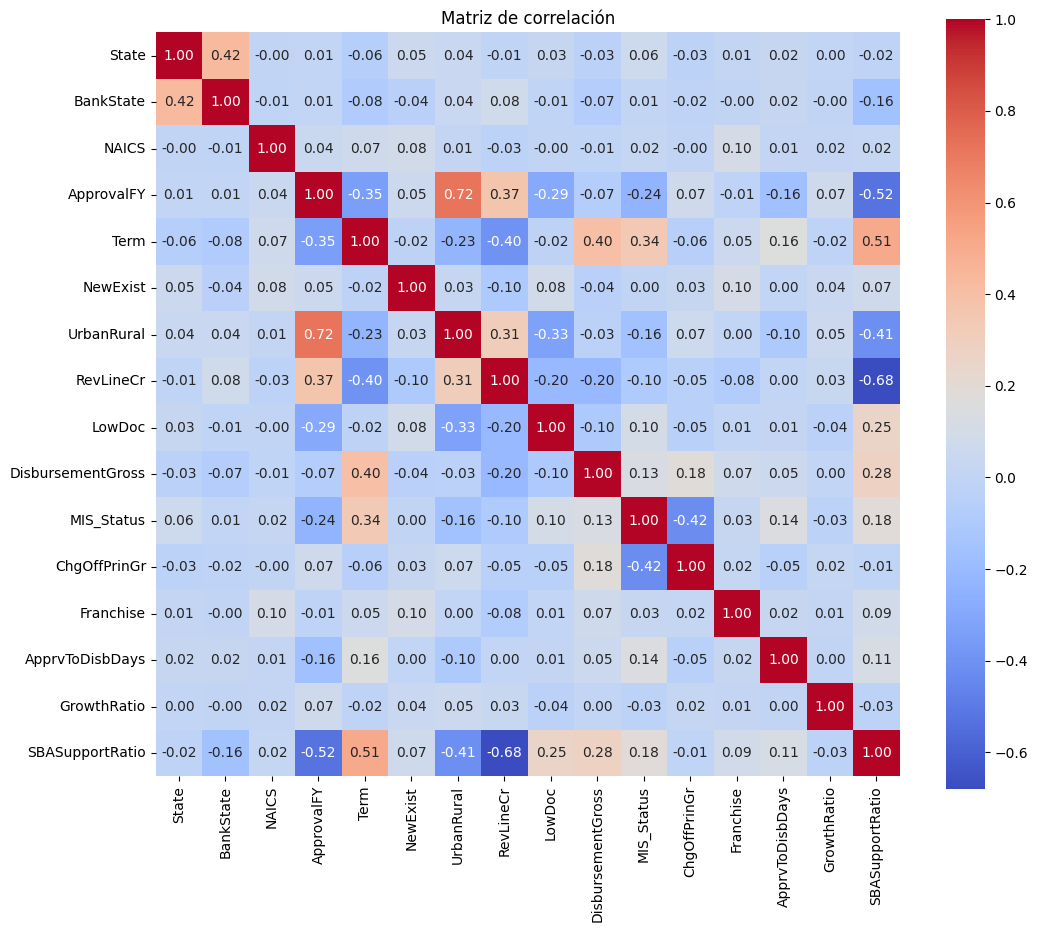

In [67]:
plt.figure(figsize=(12, 10))
sns.heatmap(dataset_numerico.corr(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Matriz de correlación')
plt.show()
plt.savefig(IMAGES_PATH + 'heatmap.png')
plt.close()

In [68]:
variables_correlacionadas = ['ApprovalFY', 'Term', 'UrbanRural', 'RevLineCr', 'LowDoc' 'DisbursementGross', 'ChgOffPrinGr', 'SBASupportRatio']
variables_sin_correlacion = ['NAICS', 'NewExist', 'Franchise', 'GrowthRatio', 'ApprvToDisbDays', 'State', 'BankState']

In [69]:
dataset = dataset_numerico.drop(columns=variables_sin_correlacion)
dataset.reset_index(drop=True, inplace=True)


df = dataset.drop(columns=['MIS_Status']).copy(deep=True)
df.reset_index(drop=True, inplace=True)


In [70]:
dataset.to_csv(DATA_PATH + 'SBAFiltered.csv', index=False)

### Escalado de los datos

In [71]:
std = StandardScaler()

In [72]:
df_std = pd.DataFrame(std.fit_transform(df), columns=df.columns)
df_std.describe(include='all')

ApprovalFY          Term    UrbanRural     RevLineCr        LowDoc  \
count  4.569480e+05  4.569480e+05  4.569480e+05  4.569480e+05  4.569480e+05   
mean  -7.563399e-17 -6.195021e-16 -4.776883e-17 -3.184589e-17  2.388442e-17   
std    1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min   -3.008750e+00 -1.372262e+00 -1.490298e+00 -8.510503e-01 -2.411009e-01   
25%   -5.339690e-01 -5.092114e-01  1.645070e-01 -8.510503e-01 -2.411009e-01   
50%    3.498813e-01 -1.435119e-01  1.645070e-01 -8.510503e-01 -2.411009e-01   
75%    7.034214e-01 -5.574403e-02  1.645070e-01  1.175019e+00 -2.411009e-01   
max    1.940812e+00  6.336683e+00  1.819312e+00  1.175019e+00  4.147641e+00   

       DisbursementGross  ChgOffPrinGr  SBASupportRatio  
count       4.569480e+05  4.569480e+05     4.569480e+05  
mean        5.150077e-17 -5.224716e-17    -9.235308e-16  
std         1.000001e+00  1.000001e+00     1.000001e+00  
min        -6.112453e-01 -2.226852e-01    -3.359509e+00  
25%        -4.985646e-01 -2.226852e-01    -8.502205e-01  
50%        -3.503914e-01 -2.226852e-01    -8.502205e-01  
75%         7.210818e-02 -2.226852e-01     9.297508e-01  
max         4.097999e+01  6.025731e+01     1.937878e+00

In [73]:
df_std.to_csv(DATA_PATH + 'SBAStandarized.csv', index=False)

## 2. Evaluación de Modelos de Aprendizaje Automático

Probaremos distintos modelos, con distintas características, e iremos filtrando hasta quedarnos con el que consideremos mejor.

In [74]:
bestests_of_models_stats : pd.DataFrame = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Accuracy High Risk', 'Accuracy Low Risk'])

### Preparación

In [25]:
dataset = pd.read_csv(DATA_PATH + 'SBAFiltered.csv', low_memory=False)
df_std = pd.read_csv(DATA_PATH + 'SBAStandarized.csv', low_memory=False)

In [26]:
x = df_std.copy(deep=True)
y = dataset['MIS_Status'].copy(deep=True)
y.reset_index(drop=True, inplace=True)

Entonces en `x` e `y` estarán los datos del data set que usaremos durante el proyecto.

#### Hiperparámetros fijos

- `Random State`: La semilla de aleatoriedad que utilizaremos para toda función que lo requiera, con el objetivo de intentar siempre recrear las mismas simulaciones.
- `Test Size`: fijado a un 40% de la muestra. El criterio de esta decisión viene dado por el motivo de tener una gran cantidad de datos. Inicialmente consideramos suficientes para entrenar el modelo correctamente.
- `Do Stratify`: Dado que la clasificación de la muestra está desbalanceada, la estratificaremos para garantizar que podamos maximizar el correcto entrenamiento de los modelos.

In [12]:
RANDOM_STATE = 234
TEST_SIZE = 0.4
DO_STRATIFY = True
classes = ('High risk', 'Low risk')

#### Hiperparámetros generales a evaluar

Depende de las restricciones con nuestros hardware disponible a la hora de probar modelos, probaremos más o menos cantidad de los siguientes parámetros:

- Coeficientes de aprendizaje
- Coeficientes de regularización

En función del modelo puede que nuestra capacidad de optimización quede limitada.

#### Definición de funciones auxiliares

In [11]:
# Función extraída de
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax, cm.astype('float')

def get_classification_metrics(y_true, y_pred, lr : float, alpha : float, model_name : str, classes) :
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"Precisión: {prec:.2f}\nRecall: {rec:.2f}\nF1: {f1:.2f}\nExactitud: {acc:.2f}\n")
    
    ax, cm = plot_confusion_matrix(y_true, y_pred, classes=classes, title=f"{model_name}(alpha={alpha}, lr={lr})")
    plt.show()
    plt.savefig(IMAGES_PATH + 'modelos/' + model_name + '/' + f'CM_{model_name}_{lr}_{alpha}.png')
    plt.close()
    
    return acc, prec, rec, f1, (cm[0][0]/(cm[0][0] + cm[0][1])), (cm[1][1]/(cm[1][0] + cm[1][1]))
    
    

#### División del conjunto de datos
Diviremos el conjunto en dos particiones de entrenamiento y prueba con las proporciones 60% y 40% de la muestra respectivamente. Dado que la muestra está desbalanceada respecto a la variable a clasificar, nos vemos obligados a estratificar las particiones para intentar mejorar el entrenamiento lo máximo posible.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y if DO_STRATIFY else None)
df_xTrain = pd.DataFrame(X_train, columns=x.columns)
df_xTest = pd.DataFrame(X_test, columns=x.columns)
df_yTrain = pd.DataFrame(y_train, columns=['MIS_Status'])
df_yTest = pd.DataFrame(y_test, columns=['MIS_Status'])

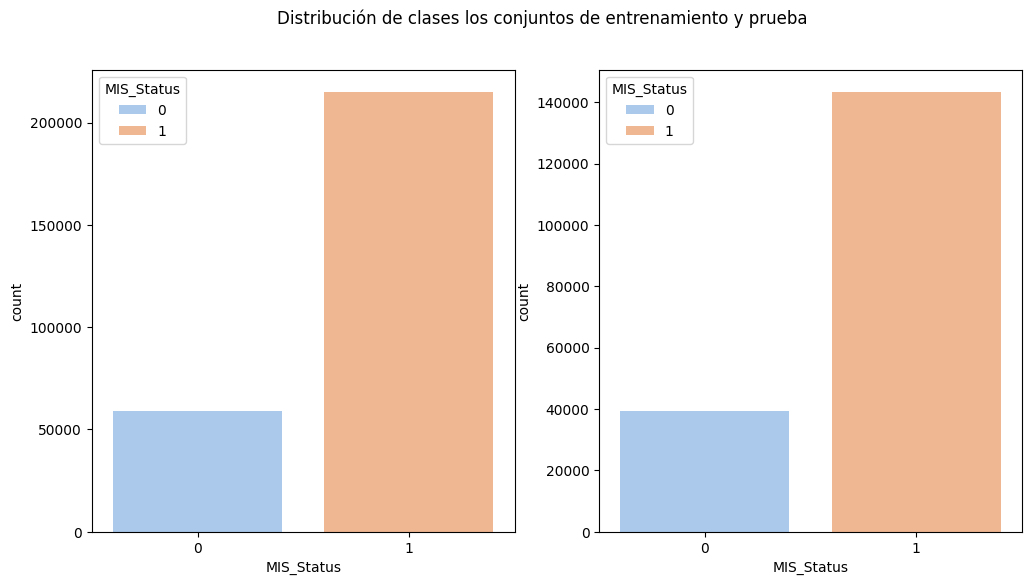

<Figure size 640x480 with 0 Axes>

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(data=df_yTrain, x='MIS_Status', ax=ax[0], hue='MIS_Status', palette='pastel')
sns.countplot(data=df_yTest, x='MIS_Status', ax=ax[1], hue='MIS_Status', palette='pastel')
plt.suptitle('Distribución de clases los conjuntos de entrenamiento y prueba')
plt.show()
plt.savefig((IMAGES_PATH + 'distribucion_clases_particiones.png'))

## Modelo Perceptrón Multicapa

Esta explicación la usaremos para justificar muchas de las decisiones tomadas en las redes neuronales.

Las condiciones que observamos son:

- Un gran conjunto de datos que nos permite entrenar modelos de mucho tipo de complejidades con menor riesgo inmediato de sobreajustar el modelo.
- Un gran desbalanceo en las clases de clasificación de los datos, lo que obliga a mantener el modelo simple para evitar que solo aprenda a identificar una de las dos clases (la mayoritaria) y confunda la otra, haciendo el modelo inútil.
- El problema es de clasificación binaria. Ésto nos ayuda a intuir que la estructura de la red no tiene que ser extremadamente profunda (tanto en capas como en neuronas).

Proporcionalmente respecto al número de datos, usaremos muy pocas neuronas. Usaremos pocas capas ocultas, pero dado el cardinal del dataset, más de una tendrá que ser usada, para difuminar la imagen obtenida de la clase mayoritaria y evitar solo aprender una de las dos clases.

Haremos pruebas con las siguientes configuraciones de capas ocultas:

In [13]:
layers =  [(512, 152, 64), (111, 55), (64, 32, 16, 8)]

Nuestro raciocinio para cada configuración:
- (512, 152, 64): Con un número moderado de capas para un problema de clasificación binaria, desescalamos la dimensionalidad con bastantes neuronas, repartidas desproporcionadamente de más a menos. Creemos que esto puede aprender la clasificación de manera óptima.
- (111, 55): Con menos capas y más neuronas por capa esperamos un efecto similar. Sospechamos que caiga en una especialización de la clase mayoritaria, por lo que las mediciones para las particiones de prueba fallen. Dado el desbalance del dataset, tendremos que medir si el error es grave o no.
- (64, 32, 16, 8): Más capas, menos neuronas por capa. Esperamos con esta configuración ser capaz de mejorar la detección de la clase minoritaria. Mediremos el riesgo de confusión entre datos de la clase mayoritaria y la minoritaria.

Como adición, probaremos los siguiente coeficientes de aprendizaje y regularización, por configuración:

In [14]:
MLP_learningRates = [0.001, 0.01, 0.1]
MLP_regularizationRates = [0.6, 0.33, 0.15]

In [15]:
best_model : tuple[MLPClassifier, float, float, float, float] = (None, 0.0, 0.0, 1.0, 0.0)
models: list[tuple[MLPClassifier, float, float, float, float]] = []

-- Entrenando con tasa de aprendizaje 0.001 y tasa de regularización 0.6 --
Iteration 1, loss = 0.12596352
Iteration 2, loss = 0.08240900
Iteration 3, loss = 0.08097553
Iteration 4, loss = 0.08049553
Iteration 5, loss = 0.08037038
Iteration 6, loss = 0.08001493
Iteration 7, loss = 0.07979881
Iteration 8, loss = 0.07972067
Iteration 9, loss = 0.07974995
Iteration 10, loss = 0.07973734
Iteration 11, loss = 0.07946313
Iteration 12, loss = 0.07944460
Iteration 13, loss = 0.07973435
Iteration 14, loss = 0.07938274
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.

Precisión: 0.99
Recall: 0.99
F1: 0.99
Exactitud: 0.99

[[ 37860   1493]
 [   936 142491]]


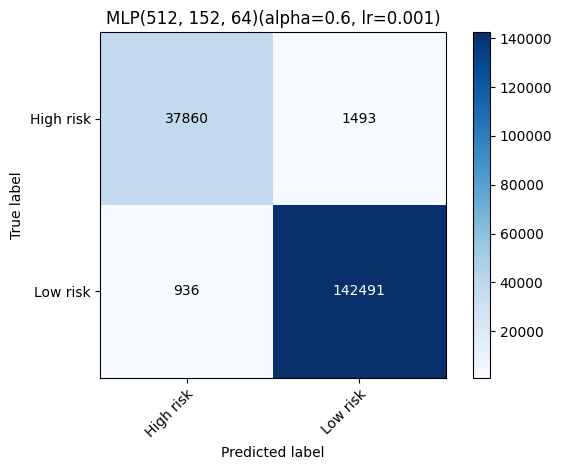

-- Entrenando con tasa de aprendizaje 0.01 y tasa de regularización 0.33 --
Iteration 1, loss = 0.08170040
Iteration 2, loss = 0.06629103
Iteration 3, loss = 0.06444275
Iteration 4, loss = 0.06410788
Iteration 5, loss = 0.06394709
Iteration 6, loss = 0.06378817
Iteration 7, loss = 0.06353846
Iteration 8, loss = 0.06342870
Iteration 9, loss = 0.06305555
Iteration 10, loss = 0.06288240
Iteration 11, loss = 0.06311619
Iteration 12, loss = 0.06266317
Iteration 13, loss = 0.06296656
Iteration 14, loss = 0.06250764
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.

Precisión: 0.99
Recall: 0.99
F1: 0.99
Exactitud: 0.99

[[ 38396    957]
 [  1004 142423]]


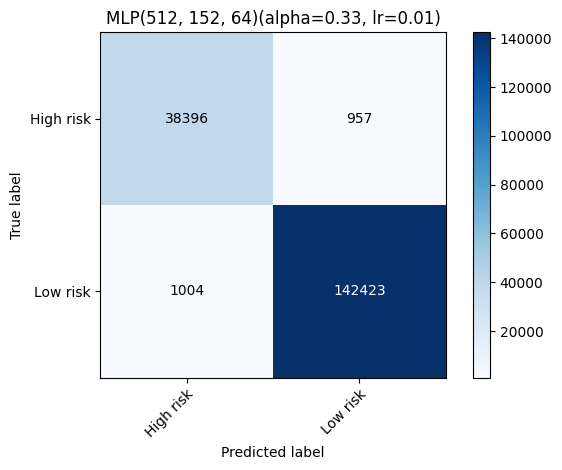

-- Entrenando con tasa de aprendizaje 0.1 y tasa de regularización 0.15 --
Iteration 1, loss = 0.29660508
Iteration 2, loss = 0.06953106
Iteration 3, loss = 0.06448451
Iteration 4, loss = 0.06467265
Iteration 5, loss = 0.06358713
Iteration 6, loss = 0.06158596
Iteration 7, loss = 0.06240159
Iteration 8, loss = 0.06255275
Iteration 9, loss = 0.06336307
Iteration 10, loss = 0.06458352
Iteration 11, loss = 0.06537841
Iteration 12, loss = 0.07223287
Iteration 13, loss = 0.06430669
Iteration 14, loss = 0.06555531
Iteration 15, loss = 0.06474818
Iteration 16, loss = 0.06317355
Iteration 17, loss = 0.06288703
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.

Precisión: 0.99
Recall: 0.99
F1: 0.99
Exactitud: 0.99

[[ 38732    621]
 [  1175 142252]]


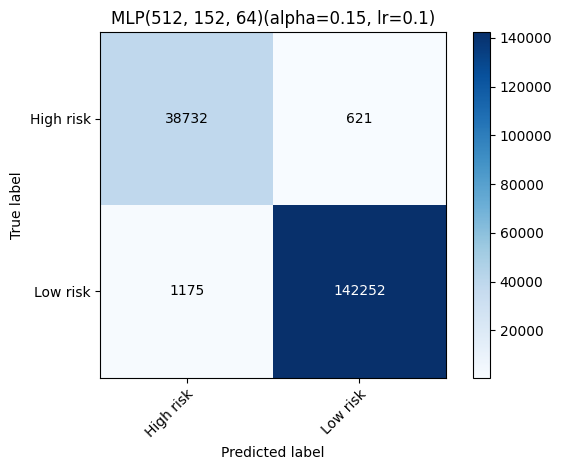

-- Entrenando con tasa de aprendizaje 0.001 y tasa de regularización 0.6 --
Iteration 1, loss = 0.14262918
Iteration 2, loss = 0.09408720
Iteration 3, loss = 0.09264023
Iteration 4, loss = 0.09208322
Iteration 5, loss = 0.09181868
Iteration 6, loss = 0.09172766
Iteration 7, loss = 0.09161261
Iteration 8, loss = 0.09154661
Iteration 9, loss = 0.09157175
Iteration 10, loss = 0.09156633
Iteration 11, loss = 0.09143038
Iteration 12, loss = 0.09143298
Iteration 13, loss = 0.09130634
Iteration 14, loss = 0.09136025
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.

Precisión: 0.99
Recall: 0.99
F1: 0.99
Exactitud: 0.99

[[ 37956   1397]
 [   967 142460]]


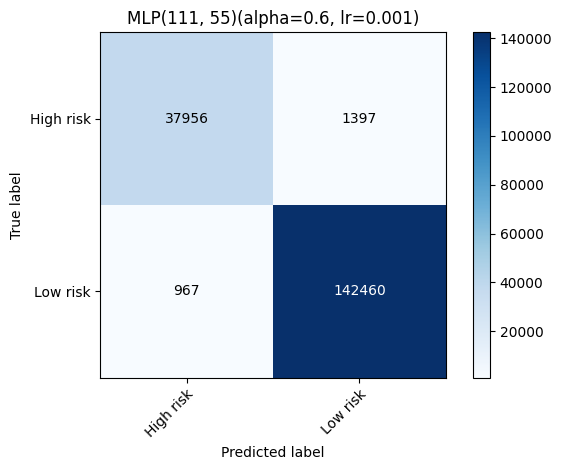

-- Entrenando con tasa de aprendizaje 0.01 y tasa de regularización 0.33 --
Iteration 1, loss = 0.08437784
Iteration 2, loss = 0.07387061
Iteration 3, loss = 0.07291158
Iteration 4, loss = 0.07241470
Iteration 5, loss = 0.07206739
Iteration 6, loss = 0.07180229
Iteration 7, loss = 0.07184993
Iteration 8, loss = 0.07159292
Iteration 9, loss = 0.07167117
Iteration 10, loss = 0.07170904
Iteration 11, loss = 0.07162140
Iteration 12, loss = 0.07146316
Iteration 13, loss = 0.07125041
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.

Precisión: 0.99
Recall: 0.99
F1: 0.99
Exactitud: 0.99

[[ 38512    841]
 [  1021 142406]]


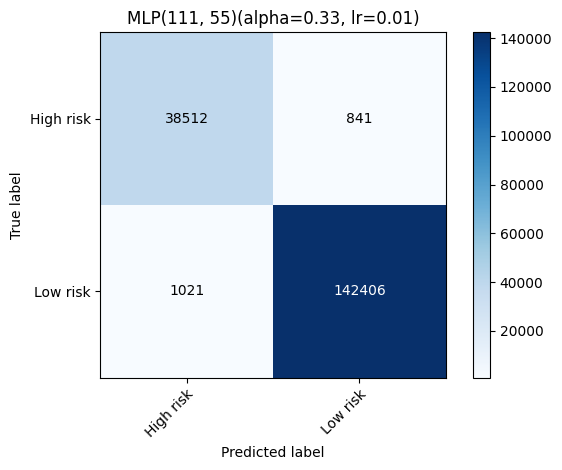

-- Entrenando con tasa de aprendizaje 0.1 y tasa de regularización 0.15 --
Iteration 1, loss = 0.08291434
Iteration 2, loss = 0.06640597
Iteration 3, loss = 0.06523671
Iteration 4, loss = 0.06512370
Iteration 5, loss = 0.06570208
Iteration 6, loss = 0.06524003
Iteration 7, loss = 0.06521357
Iteration 8, loss = 0.06515720
Iteration 9, loss = 0.06772472
Iteration 10, loss = 0.06973287
Iteration 11, loss = 0.06946326
Iteration 12, loss = 0.06832563
Iteration 13, loss = 0.06571179
Iteration 14, loss = 0.06409935
Iteration 15, loss = 0.06564559
Iteration 16, loss = 0.06501621
Iteration 17, loss = 0.06540962
Iteration 18, loss = 0.06522426
Iteration 19, loss = 0.06574394
Iteration 20, loss = 0.06611933
Iteration 21, loss = 0.06474467
Iteration 22, loss = 0.06567477
Iteration 23, loss = 0.06500218
Iteration 24, loss = 0.06627822
Iteration 25, loss = 0.06497887
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.

Precisión: 0.99
Recall: 0.99
F1: 0.99
Exact

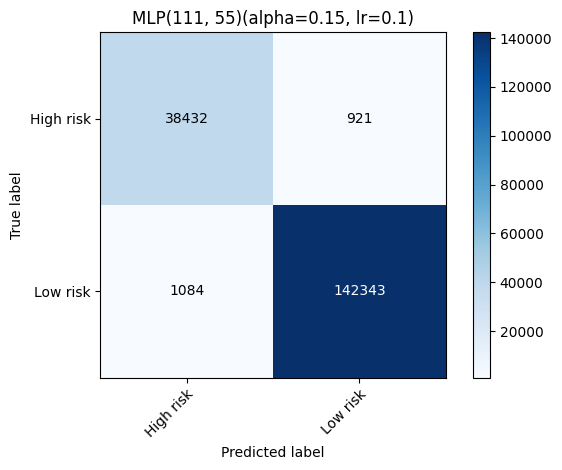

-- Entrenando con tasa de aprendizaje 0.001 y tasa de regularización 0.6 --
Iteration 1, loss = 0.14825093
Iteration 2, loss = 0.08339669
Iteration 3, loss = 0.07747646
Iteration 4, loss = 0.07570896
Iteration 5, loss = 0.07490599
Iteration 6, loss = 0.07452496
Iteration 7, loss = 0.07413642
Iteration 8, loss = 0.07396881
Iteration 9, loss = 0.07370071
Iteration 10, loss = 0.07366002
Iteration 11, loss = 0.07353837
Iteration 12, loss = 0.07354651
Iteration 13, loss = 0.07345774
Iteration 14, loss = 0.07343257
Iteration 15, loss = 0.07328291
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.

Precisión: 0.99
Recall: 0.99
F1: 0.99
Exactitud: 0.99

[[ 38670    683]
 [  1043 142384]]


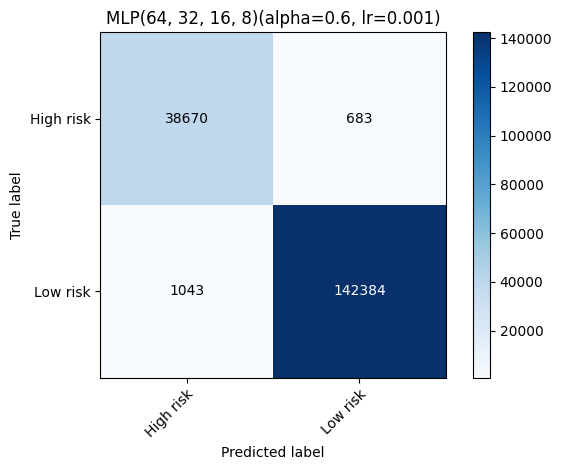

-- Entrenando con tasa de aprendizaje 0.01 y tasa de regularización 0.33 --
Iteration 1, loss = 0.07608705
Iteration 2, loss = 0.06211801
Iteration 3, loss = 0.06108887
Iteration 4, loss = 0.05994476
Iteration 5, loss = 0.05939468
Iteration 6, loss = 0.05909567
Iteration 7, loss = 0.05874520
Iteration 8, loss = 0.05895034
Iteration 9, loss = 0.05877568
Iteration 10, loss = 0.05876152
Iteration 11, loss = 0.05864212
Iteration 12, loss = 0.05870206
Iteration 13, loss = 0.05854782
Iteration 14, loss = 0.05852796
Iteration 15, loss = 0.05844252
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.

Precisión: 0.99
Recall: 0.99
F1: 0.99
Exactitud: 0.99

[[ 38808    545]
 [  1047 142380]]


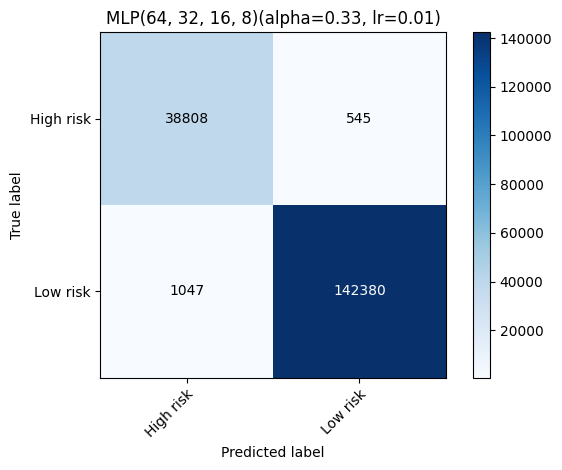

-- Entrenando con tasa de aprendizaje 0.1 y tasa de regularización 0.15 --
Iteration 1, loss = 0.08902317
Iteration 2, loss = 0.06450468
Iteration 3, loss = 0.06628325
Iteration 4, loss = 0.06221702
Iteration 5, loss = 0.06488440
Iteration 6, loss = 0.06667688
Iteration 7, loss = 0.06345806
Iteration 8, loss = 0.06501061
Iteration 9, loss = 0.06316766
Iteration 10, loss = 0.06447737
Iteration 11, loss = 0.06365539
Iteration 12, loss = 0.06289048
Iteration 13, loss = 0.06341480
Iteration 14, loss = 0.06868846
Iteration 15, loss = 0.06117065
Iteration 16, loss = 0.06372712
Iteration 17, loss = 0.06421456
Iteration 18, loss = 0.06343386
Iteration 19, loss = 0.06304017
Iteration 20, loss = 0.06565239
Iteration 21, loss = 0.06341426
Iteration 22, loss = 0.06958294
Iteration 23, loss = 0.06491664
Iteration 24, loss = 0.06404180
Iteration 25, loss = 0.06335886
Iteration 26, loss = 0.06444879
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.

Precisión: 

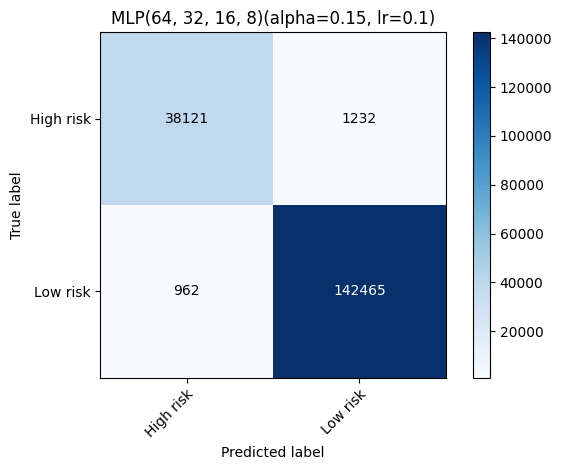

In [16]:
for layer in layers :
    for alpha, lr in zip(MLP_regularizationRates, MLP_learningRates) :
        print(f"-- Entrenando con tasa de aprendizaje {lr} y tasa de regularización {alpha} --")
        
        mlp = MLPClassifier(
            hidden_layer_sizes=layer,
            alpha=alpha,
            learning_rate_init=lr,
            max_iter=1000,
            shuffle=True,
            random_state=RANDOM_STATE,
            verbose=True,
            tol=0.001
        )
        
        mlp.fit(X_train, y_train)
        print()
        
        y_pred = mlp.predict(X_test)
        
        acc, prec, rec, f1, cm, *_ = get_classification_metrics(y_test, y_pred, lr, alpha, f"MLP{layer}", classes)
        
        # General F1 score
        # F1 = 2 * (precision * recall) / (precision + recall)
        if (2*prec*rec)/(prec + rec) > (2*best_model[2]*best_model[3])/(best_model[2] + best_model[3]) :
            best_model = (mlp, acc, prec, rec, f1)
            
        models.append((mlp, acc, prec, rec, f1))
        
        

In [17]:
print(f"Mejor modelo:\nPrecisión: {best_model[1]:.2f}\nRecall: {best_model[2]:.2f}\nF1: {best_model[3]:.2f}\nExactitud: {best_model[4]:.2f}\n")
print(f"Modelo MLP{best_model[0].get_params().get('hidden_layer_sizes')}(alpha: {best_model[0].get_params().get('alpha')}, lr: {best_model[0].get_params().get('learning_rate_init')})")

Mejor modelo:
Precisión: 0.99
Recall: 0.99
F1: 0.99
Exactitud: 0.99

Modelo MLP(64, 32, 16, 8)(alpha: 0.33, lr: 0.01)


Sorprendentemente, observamos un alto sobre ajuste de los modelos. Las configuraciones son muy buenas. Tras mucho pensarlo, cabe la posibilidad de que tengamos que aceptar este sobreajuste. El motivo es que el hecho de que la muestra esté desbalanceada quizás sea el suceso natural para el contexto del problema. Necesitamos el sobre ajuste para evitar confundir las clases. El inconveniente es la mala respuesta que tendrá el modelo a datos nuevos que no sigan el patrón.

In [18]:
# Guardamos el mejor modelo
modelo = best_model[0]
joblib.dump(modelo, DATA_PATH + 'models/MLPClassifier.joblib')

['./data/models/MLPClassifier.joblib']

Precisión: 0.99
Recall: 0.99
F1: 0.99
Exactitud: 0.99

[[ 38808    545]
 [  1047 142380]]


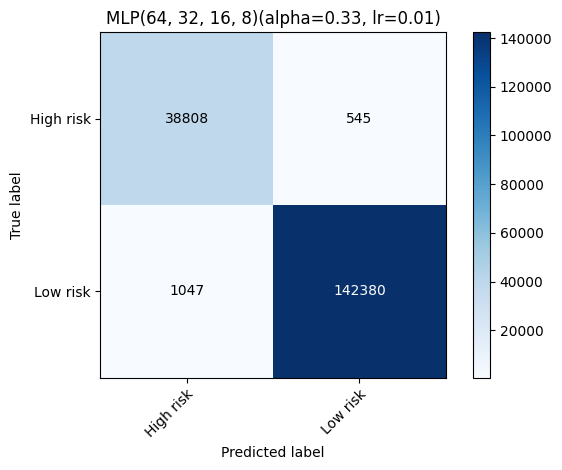

In [19]:
modelo = joblib.load(DATA_PATH + 'models/MLPClassifier.joblib')
acc, prec, rec, f1, acc_c0, acc_c1 = get_classification_metrics(y_test, modelo.predict(X_test), modelo.get_params().get('learning_rate_init'), modelo.get_params().get('alpha'), f"MLP{modelo.get_params().get('hidden_layer_sizes')}", classes)


In [20]:
print(f"Mejor modelo:\nPrecisión: {acc:.2f}\nRecall: {rec:.2f}\nF1: {f1:.2f}\nExactitud: {prec:.2f}\nPrecisión alto riesgo: {acc_c0:.2f}\nPrecisión bajo riesgo: {acc_c1:.2f}\n")
print(f"Modelo MLP{modelo.get_params().get('hidden_layer_sizes')}(alpha: {modelo.get_params().get('alpha')}, lr: {modelo.get_params().get('learning_rate_init')})")

Mejor modelo:
Precisión: 0.99
Recall: 0.99
F1: 0.99
Exactitud: 0.99
Precisión alto riesgo: 0.99
Precisión bajo riesgo: 0.99

Modelo MLP(64, 32, 16, 8)(alpha: 0.33, lr: 0.01)


In [89]:
bestests_of_models_stats = pd.concat([bestests_of_models_stats, pd.DataFrame([
    {
        'Model' : f"MLP{modelo.get_params().get('hidden_layer_sizes')}(alpha: {modelo.get_params().get('alpha')}, lr: {modelo.get_params().get('learning_rate_init')})",
        'Accuracy' : acc,
        'Precision' : prec,
        'Recall' : rec,
        'F1-Score' : f1,
        'Accuracy High Risk' : acc_c0,
        'Accuracy Low Risk' : acc_c1
    }
])], ignore_index=True, axis=0, )
bestests_of_models_stats

/var/folders/dn/z802f2_d7g73lkp9775vjs740000gn/T/ipykernel_36524/2394653884.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bestests_of_models_stats = pd.concat([bestests_of_models_stats, pd.DataFrame([


Model  Accuracy  Precision    Recall  \
0  MLP(64, 32, 16, 8)(alpha: 0.33, lr: 0.01)  0.991334   0.991397  0.991334   

   F1-Score  Accuracy High Risk  Accuracy Low Risk  
0  0.991354             0.98638           0.992693

## Modelo de Red Neuronal Convolucional

### Configuración inicial de CUDA y datos

In [90]:
torch.manual_seed(RANDOM_STATE)

# Modificar estos booleanos para usar CUDA o MPS en función de preferencias personales
doYouWantToUseCUDA = True
doYouWantToUseMPS = True

device = torch.device("cpu")

if doYouWantToUseCUDA and torch.cuda.is_available():
    device = torch.device("cuda")
elif doYouWantToUseMPS and torch.backends.mps.is_available():
    device = torch.device("mps")
#else:
    #device = torch.device("cpu")
print(f"Dispositivo: {device}")

Dispositivo: mps


In [91]:
t_Xtrain = torch.tensor(X_train.values, dtype=torch.float)
t_ytrain = torch.tensor(y_train.values, dtype=torch.long)
t_Xtest = torch.tensor(X_test.values, dtype=torch.float)
t_ytest = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(t_Xtrain, t_ytrain)
test_dataset = TensorDataset(t_Xtest, t_ytest)

Esta explicación la usaremos para justificar muchas de las decisiones tomadas en las redes neuronales.

Las condiciones que observamos son:

- Un gran conjunto de datos que nos permite entrenar modelos de mucho tipo de complejidades con menor riesgo inmediato de sobreajustar el modelo.
- Un gran desbalanceo en las clases de clasificación de los datos, lo que obliga a mantener el modelo simple para evitar que solo aprenda a identificar una de las dos clases (la mayoritaria) y confunda la otra, haciendo el modelo inútil.
- El problema es de clasificación binaria. Ésto nos ayuda a intuir que la estructura de la red no tiene que ser extremadamente profunda (tanto en capas como en neuronas).

Probaremos dos configuraciones:

- Una compleja con dos capas convolucionales, una de pooling y dos finales con bastantes neuronas. El objetivo es generar un modelo complejo al cual le pasaremos hiperparámetros pequeños para ver si conseguimos aprovecharnos de la complejidad del modelo lo suficiente como para que haga una buena clasificación sin sobreajustarlo.
- Una simple, con una capa convolucional, una de pooling y una final con un rápido descalado de dimensiones. Intentamos minimizar el modelo para que sea capaz de entrenar sin infraajustar.

In [92]:
class ComplexCNN(nn.Module) :
    def __init__(self, batch, epochs, learning_rate):
        super(ComplexCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(4, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, 2)
        
        self.batch_size = batch
        self.epochs = epochs
        self.lr = learning_rate

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def get_epochs(self) : return self.epochs
    
    def get_batchSize(self) : return self.batch_size
    
    def get_lr(self) : return self.lr
    
    def get_name(self) : return 'ComplexCNN'
        

In [93]:
class SimpleCNN(nn.Module) : 
    def __init__(self, batch, epochs, learning_rate):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Conv1d(1, 4, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc = nn.Linear(16, 2)
        
        self.batch_size = batch
        self.epochs = epochs
        self.lr = learning_rate
        
    def forward(self, x):
        x = x.unsqueeze(1)  # Añadir dimensión de canal
        x = F.relu(self.conv(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
    def get_epochs(self) : return self.epochs
    
    def get_batchSize(self) : return self.batch_size
    
    def get_lr(self) : return self.lr
    
    def get_name(self) : return 'SimpleCNN'

Con la siguiente función de entrenamiento:

In [94]:
def epoch(
    model, 
    trainloader, 
    optimizer, 
    criterion, 
    epoch, 
    device=device, 
    verbose=True  
) :
    model.train()
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if verbose and batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(trainloader.dataset)} ({100. * batch_idx / len(trainloader):.0f}%)]\tLoss: {loss.item():.6f}')
            
def train(
    model,
    trainLoader,
    optimizer,
    criterion,
    device=device,
    verbose=True
) :
    for etapa in range(model.get_epochs()) :
        epoch(model, trainLoader, optimizer, criterion, etapa, device, verbose)
        print(f"Epoch {etapa} finished\n")

Respecto a las funciones de evaluación que usaremos, tendremos una que nos dé la pérdida del coste y la precisión del modelo; y otra que nos dé la precisión por clase. Esto nos dará información suficiente para entender el resultado de las redes

In [95]:
def test(
    model, 
    testloader, 
    criterion, 
    device=device, 
    verbose=True  
) :
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            _, pred = torch.max(output, 1)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    if verbose:
        print(f'\nTest set: Average loss: {test_loss / len(testloader.dataset):.4f}, Accuracy: {correct}/{len(testloader.dataset)} ({100. * correct / len(testloader.dataset):.0f}%)\n')

    return (test_loss / len(testloader.dataset)), (100. * correct / len(testloader.dataset))
        
def test_per_class(
    model,
    testloader : DataLoader,
    classes,
    device=device,
) :
    # diccionarios para contar las predicciones correctas y el total de predicciones por clase, inicializados a 0
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
            
            # contamos las predicciones correctas y el total de predicciones por clase
            for label, prediction in zip(target, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
    
    _, cm = plot_confusion_matrix(np.array(all_labels), np.array(all_preds), classes=classes, title=model.get_name())
    plt.savefig(IMAGES_PATH + 'modelos/' + model.get_name() + '/' + f'CM_{model.get_name()}.png')
    plt.show()
    plt.close()
    
    accuracies = []
    
    # verbose per class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
        accuracies.append(accuracy)
    
    # clase 0 (alto riesgo), clase 1 (bajo riesgo), recall, f1, precision
    
    recall = cm[0][0] / (cm[0][0] + cm[0][1])
    precision = cm[0][0] / (cm[0][0] + cm[1][0])
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracies, recall, precision, f1

### Optimizador y medida del coste

Utilizaremos la herramienta dada en clase de la función de coste _entropy loss_

In [96]:
criterion = nn.CrossEntropyLoss()

Utilizaremos la optimización tipo Adam porque es la que mejor se adapta en general, y dado que no hemos profundizado en este tipo de temas, será el optimizador que usemos.

### Hiperparámetros

En el caso de los hiperparámetros a considerar en este modelo, consideraremos:
- Tamaño de submuestra (batch): dado que el conjunto de datos es muy grande, los batch de prueba que usemos, se mediran, como mínimo, en millares.
- Etapas: basándonos un poco en los resultados del perceptrón, intuimos resultados en iteraciones similares.
- Coeficiente de aprendizaje: Siguiendo los resultados del perceptrón, seguiremos coeficientes de aprendizaje entre la centena y milésima, dado el gran tamaño del dataset

In [97]:
complex_batch = 32
complex_epochs = 11
complex_lr = 0.001

simple_batch = 64
simple_epochs = 15
simple_lr = 0.005

### Ejecución de los modelos

Creamos las redes:

In [98]:
redCompleja = ComplexCNN(complex_batch, complex_epochs, complex_lr).to(device)

In [99]:
# Gestor de datos para la red compleja
ComplexCNN_TrainLoader = DataLoader(train_dataset, batch_size=redCompleja.get_batchSize(), shuffle=True)
ComplexCNN_TestLoader = DataLoader(test_dataset, batch_size=redCompleja.get_batchSize(), shuffle=False)

# Optimizador para la red compleja
complexOptimizer = optim.Adam(redCompleja.parameters(), lr=redCompleja.get_lr())

In [100]:
redSimple = SimpleCNN(simple_batch, simple_epochs, simple_lr).to(device)

In [101]:
# Gestor de datos para la red simple
SimpleCNN_TrainLoader = DataLoader(train_dataset, batch_size=redSimple.get_batchSize(), shuffle=True)
SimpleCNN_TestLoader = DataLoader(test_dataset, batch_size=redSimple.get_batchSize(), shuffle=False)

# Optimizador para la red simple
simpleOptimizer = optim.Adam(redSimple.parameters(), lr=redSimple.get_lr())

In [102]:
train(redCompleja, ComplexCNN_TrainLoader, complexOptimizer, criterion, device, verbose=True)
torch.save(redCompleja.state_dict(), DATA_PATH + 'models/CNNs/ComplexCNN.pth')

Train Epoch: 0 [0/274168 (0%)]	Loss: 0.682481
Train Epoch: 0 [3200/274168 (1%)]	Loss: 0.514481
Train Epoch: 0 [6400/274168 (2%)]	Loss: 0.261244
Train Epoch: 0 [9600/274168 (4%)]	Loss: 0.089812
Train Epoch: 0 [12800/274168 (5%)]	Loss: 0.106161
Train Epoch: 0 [16000/274168 (6%)]	Loss: 0.120944
Train Epoch: 0 [19200/274168 (7%)]	Loss: 0.251053
Train Epoch: 0 [22400/274168 (8%)]	Loss: 0.051851
Train Epoch: 0 [25600/274168 (9%)]	Loss: 0.062540
Train Epoch: 0 [28800/274168 (11%)]	Loss: 0.095086
Train Epoch: 0 [32000/274168 (12%)]	Loss: 0.249035
Train Epoch: 0 [35200/274168 (13%)]	Loss: 0.029022
Train Epoch: 0 [38400/274168 (14%)]	Loss: 0.010660
Train Epoch: 0 [41600/274168 (15%)]	Loss: 0.077544
Train Epoch: 0 [44800/274168 (16%)]	Loss: 0.030274
Train Epoch: 0 [48000/274168 (18%)]	Loss: 0.285958
Train Epoch: 0 [51200/274168 (19%)]	Loss: 0.005502
Train Epoch: 0 [54400/274168 (20%)]	Loss: 0.007003
Train Epoch: 0 [57600/274168 (21%)]	Loss: 0.015979
Train Epoch: 0 [60800/274168 (22%)]	Loss: 0.003

In [103]:
train(redSimple, SimpleCNN_TrainLoader, simpleOptimizer, criterion, device, verbose=True)
torch.save(redSimple.state_dict(), DATA_PATH + 'models/CNNs/SimpleCNN.pth')

Train Epoch: 0 [0/274168 (0%)]	Loss: 0.643628
Train Epoch: 0 [6400/274168 (2%)]	Loss: 0.344359
Train Epoch: 0 [12800/274168 (5%)]	Loss: 0.304285
Train Epoch: 0 [19200/274168 (7%)]	Loss: 0.186451
Train Epoch: 0 [25600/274168 (9%)]	Loss: 0.274059
Train Epoch: 0 [32000/274168 (12%)]	Loss: 0.212999
Train Epoch: 0 [38400/274168 (14%)]	Loss: 0.130449
Train Epoch: 0 [44800/274168 (16%)]	Loss: 0.206343
Train Epoch: 0 [51200/274168 (19%)]	Loss: 0.225890
Train Epoch: 0 [57600/274168 (21%)]	Loss: 0.279841
Train Epoch: 0 [64000/274168 (23%)]	Loss: 0.183643
Train Epoch: 0 [70400/274168 (26%)]	Loss: 0.111965
Train Epoch: 0 [76800/274168 (28%)]	Loss: 0.125867
Train Epoch: 0 [83200/274168 (30%)]	Loss: 0.143722
Train Epoch: 0 [89600/274168 (33%)]	Loss: 0.254842
Train Epoch: 0 [96000/274168 (35%)]	Loss: 0.088487
Train Epoch: 0 [102400/274168 (37%)]	Loss: 0.096087
Train Epoch: 0 [108800/274168 (40%)]	Loss: 0.113462
Train Epoch: 0 [115200/274168 (42%)]	Loss: 0.109932
Train Epoch: 0 [121600/274168 (44%)]	L


Test set: Average loss: 0.0009, Accuracy: 181493/182780 (99%)

[[ 39180    173]
 [  1114 142313]]


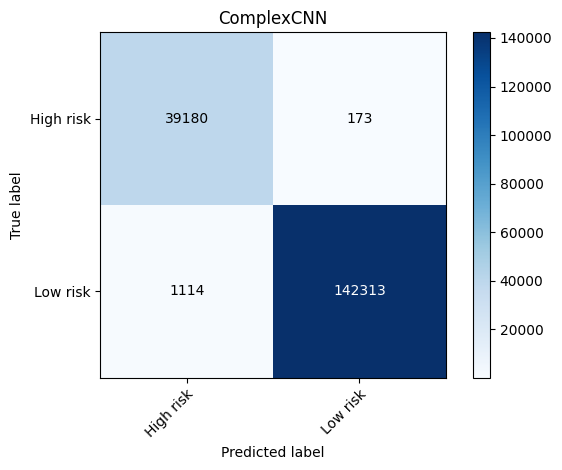

Accuracy for class: High risk is 99.6 %
Accuracy for class: Low risk is 99.2 %
Precisión: 0.97
Recall: 1.00
F1: 0.98



In [104]:
redCompleja.load_state_dict(torch.load(DATA_PATH + 'models/CNNs/ComplexCNN.pth'))
complex_loss_ratio, complex_accuracy = test(redCompleja, ComplexCNN_TestLoader, criterion, device, verbose=True)
complex_class_accuracies, complex_rec, complex_prec, complex_f1 = test_per_class(redCompleja, ComplexCNN_TestLoader, classes, device)
print(f"Precisión: {complex_prec:.2f}\nRecall: {complex_rec:.2f}\nF1: {complex_f1:.2f}\n")

In [ ]:
redSimple.load_state_dict(torch.load(DATA_PATH + 'models/CNNs/SimpleCNN.pth'))
simple_loss_ratio, simple_accuracy = test(redSimple, SimpleCNN_TestLoader, criterion, device, verbose=True)
simple_class_accuracies, simple_rec, simple_prec, simple_f1 = test_per_class(redSimple, SimpleCNN_TestLoader, classes, device)
print(f"Precisión: {simple_prec:.2f}\nRecall: {simple_rec:.2f}\nF1: {simple_f1:.2f}\n")


Test set: Average loss: 0.0010, Accuracy: 180625/182780 (99%)



Observamos que para ambos modelos conseguimos clasificaciones perfectas, a pesar de la escasez de neuronas usadas y la simplicidad de los parámetros. No resulta relevante la complejidad de la arquitectura de la red neuronal.

Entre ambos modelos, preferimos quedarnos con el modelo más simple, por cuestiones de eficiencia en recursos y espacio.

In [ ]:

bestests_of_models_stats = pd.concat([bestests_of_models_stats, pd.DataFrame([
    {
        'Model' : f"SimpleCNN(batch: {redSimple.get_batchSize()}, epochs: {redSimple.get_epochs()}, lr: {redSimple.get_lr()})",
        'Accuracy' : simple_accuracy * 0.01,
        'Precision' : simple_prec,
        'Recall' : simple_rec,
        'F1-Score' : simple_f1,
        'Accuracy High Risk' : simple_class_accuracies[0] * 0.01,
        'Accuracy Low Risk' : simple_class_accuracies[1] * 0.01
    }
])], ignore_index=True, axis=0)
bestests_of_models_stats

In [ ]:
bestests_of_models_stats.to_csv(DATA_PATH + 'BestModelsStats.csv', index=False)

# Modelo KNN

KNN es un algoritmo supervisado de clasificación que clasifica un nuevo putno de datos basandose en la clase mayoritaria entre sus K vecinos más cercanos en el conjunto de entrenamiento.
- Es versatil y fácil de entender
- Puede capturar relaciones locales a diferencia de redes neuronales (sin necesidad de un ajuste complejo)
  
¿Qué puede aportar?
- Simplicidad interpretativa
- Punto de comparación clasico, aunque MLP y CNN logran F1 altísimas, KNN puede dar un punto medio para mostrar que el éxito no depende solo de modelos complejos.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import os

# Aseguramos la ruta de modelos
model_path = './data/models/KNNClassifier.joblib'
if not os.path.exists(os.path.dirname(model_path)):
    os.makedirs(os.path.dirname(model_path))

In [ ]:
# Lista de valores de K a probar
k_values = [3, 5, 7, 9, 11]
knn_results = []
best_f1 = 0
best_knn = None
best_k = 0

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"K = {k}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Mostrar matriz de confusión y guardar imagen
    classes = ["High Risk", "Low Risk"]
    ax, cm = plot_confusion_matrix(y_test, y_pred, classes=classes, 
                               title=f"KNN Confusion Matrix (K={k})")

    plt.savefig(f"./images/modelos/CM_KNN_K{k}.png")
    plt.show()
    plt.close()
    
    knn_results.append((k, acc, prec, rec, f1))
    
    if f1 > best_f1:
        best_f1 = f1
        best_knn = knn
        best_k = k

# Guardar el mejor modelo
joblib.dump(best_knn, model_path)
print(f"\nMejor modelo KNN guardado (K = {best_k}) con F1 = {best_f1:.4f}")

## ¿Por qué K = 3?
El valor K=3 ofrece el mejor rendimiento porque permite al modelo capturar con precisión la estructura local del espacio de características, evitando la suavización excesiva que ocurre con valores mayores de K. Dado que los datos son bien separables y tienen zonas densas de una sola clase, pocos vecinos son suficientes para tomar decisiones correctas sin caer en sobreajuste. Esto demuestra que, en datasets con patrones claros, un K pequeño es capaz de maximizar la sensibilidad sin sacrificar generalización.

In [ ]:
bestests_of_models_stats = pd.concat([bestests_of_models_stats, pd.DataFrame([
    {
        'Model' : f"KNNClassifier (k={best_k})",
        'Accuracy' : acc,
        'Precision' : prec,
        'Recall' : rec,
        'F1-Score' : f1,
        'Accuracy High Risk' : cm[0][0] / (cm[0][0] + cm[0][1]),
        'Accuracy Low Risk' : cm[1][1] / (cm[1][0] + cm[1][1])
    }
])], ignore_index=True)


In [ ]:
bestests_of_models_stats.to_csv(DATA_PATH + 'BestModelsStats.csv', index=False)


# Modelo Regresion Logistica 

## ¿Por qué usar Regeresión Logistica? ¿Qué nos puede aportar que otros modelos no?

A diferencia de redes neuronales o KNN, este modelo ofrece coeficientes directamente interpretables, lo que permite entender cómo cada variable afecta la probabilidad de impago.Es util para ver si un problema se puede resolver bien con un modelo lineal.

A pesar de haber porbado modelos potentes como MLP o CNN, si su rendimiento es cercanos a ellos reforzará la idea de que el problema es linealmente separable o que los patrones están muy marcados.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import os

# Asegura la carpeta para guardar el modelo
model_path = './data/models/LogisticRegression.joblib'
if not os.path.exists(os.path.dirname(model_path)):
    os.makedirs(os.path.dirname(model_path))

In [ ]:
# Valores de C a probar (inverso de regularización)
c_values = [0.01, 0.1, 1, 10]
logreg_results = []
best_f1 = 0
best_model = None
best_c = 0

classes = ["High Risk", "Low Risk"]

for c in c_values:
    logreg = LogisticRegression(C=c, penalty='l2', solver='liblinear', max_iter=1000)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"C = {c}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Matriz de confusión
    ax, cm = plot_confusion_matrix(y_test, y_pred, classes=classes, 
                                   title=f"Logistic Regression (C={c})")
    plt.savefig(f"./images/modelos/CM_LogReg_C{c}.png")
    plt.show()
    plt.close()
    
    logreg_results.append((c, acc, prec, rec, f1))
    
    if f1 > best_f1:
        best_f1 = f1
        best_model = logreg
        best_c = c

# Guardar el mejor modelo
joblib.dump(best_model, model_path)
print(f"\nMejor modelo de regresión logística guardado (C = {best_c}) con F1 = {best_f1:.4f}")

La regresión logística ha demostrado un rendimiento muy competitivo, alcanzando un F1 Score de 0.9839 con un valor de regularización óptimo de C = 10. Aunque sus resultados quedan ligeramente por debajo de los obtenidos con modelos más complejos como el MLP (~0.9901) o la CNN (0.9900), logra clasificar correctamente más del 98% de los préstamos, lo que la posiciona como una alternativa eficaz.

Se observa que, a medida que se reduce la regularización (es decir, al aumentar el valor de C), el modelo mejora su capacidad predictiva. Esto sugiere que el problema presenta una estructura suficientemente clara como para que un modelo lineal, con cierta flexibilidad, logre capturar patrones relevantes sin caer en sobreajuste. Con C = 10, se registraron 37.292 impagos y 142.557 pagos correctamente clasificados, reflejando un buen equilibrio entre sensibilidad y precisión.

Aunque el rendimiento de KNN y MLP es marginalmente superior, la principal ventaja de la regresión logística radica en:
- Su simplicidad conceptual y facilidad de implementación.
- La posibilidad de interpretar directamente el peso de cada variable.
- Su eficiencia computacional, incluso con grandes volúmenes de datos.
- Y su robustez, especialmente en entornos donde se valoran modelos estables y explicables.

En definitiva, esta técnica se presenta como una opción sólida y práctica para escenarios donde se prioriza la transparencia del modelo y la agilidad en su aplicación, sin renunciar a un nivel de precisión muy alto.

### ¿Qúe variables aumentan el riesgo de impago?

In [ ]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cargar el modelo entrenado
logreg = joblib.load('./data/models/LogisticRegression.joblib')

# 2. Obtener nombres de variables
feature_names = X_train.columns

# 3. Extraer coeficientes
coefficients = logreg.coef_[0]  # Solo hay una salida binaria

# 4. Crear tabla
coef_df = pd.DataFrame({
    'Variable': feature_names,
    'Coeficiente': coefficients
})

# 5. Ordenar por impacto
coef_df = coef_df.sort_values(by='Coeficiente', ascending=False).reset_index(drop=True)

# 6. Mostrar tabla
display(coef_df)


In [ ]:
# Gráfico de coeficientes ordenados
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Variable'], coef_df['Coeficiente'], color='skyblue')
plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Importancia de las variables en la regresión logística')
plt.xlabel('Coeficiente (impacto en la probabilidad de pagar)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


El análisis de los coeficientes en la regresión logística nos ha permitido ver qué variables influyen más en si un préstamo se paga o no. La que más destaca es ChgOffPrinGr, con un valor muy negativo, lo cual tiene sentido porque representa el importe que no se devolvió; básicamente, si este valor es alto, casi seguro que el préstamo acabó en impago. Aunque esto introduce cierta fuga de información, también confirma que el modelo está captando bien el comportamiento esperado.

Entre las variables que aumentan la probabilidad de pago destacan el importe del préstamo (DisbursementGross) y su duración (Term), lo que puede reflejar que negocios más estables reciben más financiación y más tiempo para devolverla. También sorprende que los préstamos con documentación reducida (LowDoc) no se comportan peor, lo que podría deberse a filtros previos bien aplicados.

En cambio, una mayor garantía por parte de la SBA (SBASupportRatio) o préstamos más recientes (ApprovalFY) parecen estar asociados a más riesgo, aunque su impacto es menor. Otras variables como si el préstamo fue en zona urbana o si era una línea de crédito (RevLineCr) tienen poca relevancia.

In [ ]:
bestests_of_models_stats = pd.concat([bestests_of_models_stats, pd.DataFrame([
    {
        'Model' : f"LogisticRegression (C={best_c})",
        'Accuracy' : acc,
        'Precision' : prec,
        'Recall' : rec,
        'F1-Score' : f1,
        'Accuracy High Risk' : cm[0][0] / (cm[0][0] + cm[0][1]),
        'Accuracy Low Risk' : cm[1][1] / (cm[1][0] + cm[1][1])
    }
])], ignore_index=True)


In [ ]:
bestests_of_models_stats.to_csv(DATA_PATH + 'BestModelsStats.csv', index=False)


# Modelos de Árbol de Decisión

### ¿Qué aporta este modelo frente a los ya explicados?

- A diferencia del resto no requiere escalado ni normalización,funciona directamente con los valores originales.
- Si hay interacciones entre variables, el árbol puede descubrirlas de forma natural
- Puedes ajustar la profundidad del árbol (max_depth) para evitar sobreajuste y encontrar un buen balance entre precisión e interpretabilidad.

### ¿Qué buscamos al usarlo
- Evaluar qué variables son seleccionadas primero por el árbol (es decir, cuáles se consideran más informativas).
- Ver si un modelo basado en reglas simples puede competir en rendimiento con modelos más complejos.
- Obtener una visión explicable y visual del proceso de decisión del modelo.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import os

# Crear ruta si no existe
model_path = './data/models/DecisionTreeClassifier.joblib'
if not os.path.exists(os.path.dirname(model_path)):
    os.makedirs(os.path.dirname(model_path))

In [ ]:
# Probar distintos niveles de profundidad
depth_values = [3, 5, 7, 10, 15]
tree_results = []
best_f1 = 0
best_model = None
best_depth = 0

classes = ["High Risk", "Low Risk"]

for depth in depth_values:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=234)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"max_depth = {depth}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Matriz de confusión
    ax, cm = plot_confusion_matrix(y_test, y_pred, classes=classes,
                                   title=f"Decision Tree (depth={depth})")
    plt.savefig(f"./images/modelos/CM_DecisionTree_Depth{depth}.png")
    plt.show()
    plt.close()

    tree_results.append((depth, acc, prec, rec, f1))

    if f1 > best_f1:
        best_f1 = f1
        best_model = tree
        best_depth = depth

# Guardar el mejor árbol
joblib.dump(best_model, model_path)
print(f"\nMejor modelo de árbol guardado (max_depth = {best_depth}) con F1 = {best_f1:.4f}")

El modelo de árbol de decisión ha logrado un rendimiento sobresaliente con una profundidad muy baja (max_depth = 3), alcanzando un F1 Score de 0.9936, lo que lo sitúa como el modelo con mejor precisión en este conjunto de pruebas.

Esta profundidad tan reducida indica que el modelo ha sido capaz de generar reglas simples y efectivas para separar los préstamos impagados de los pagados, sin necesidad de sobreajustar. A medida que se incrementó la profundidad, el rendimiento no solo no mejoró, sino que comenzó a empeorar levemente, lo cual refuerza la idea de que el árbol ya había capturado los patrones esenciales desde niveles muy tempranos.

Este resultado destaca la fuerza explicativa del árbol: con apenas unas pocas divisiones, es capaz de clasificar correctamente más del 99% de los préstamos. Además, al tratarse de un modelo totalmente interpretable, sería especialmente útil en contextos donde se requiere justificar decisiones o entender qué reglas llevan a rechazar o aprobar un préstamo.

En resumen, el árbol de decisión no solo es competitivo frente a modelos complejos como redes neuronales, sino que además aporta claridad y simplicidad, lo que lo convierte en una herramienta poderosa y práctica en problemas de clasificación binaria como este.

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import joblib

# 1. Cargar el modelo guardado
tree_model = joblib.load('./data/models/DecisionTreeClassifier.joblib')

# 2. Crear el gráfico del árbol
plt.figure(figsize=(20, 10))
plot_tree(tree_model, 
          feature_names=X_train.columns, 
          class_names=["High Risk", "Low Risk"],
          filled=True, 
          rounded=True,
          fontsize=10)
plt.title("Árbol de Decisión (max_depth = 3)")
plt.show()


El árbol de decisión con solo 3 niveles de profundidad consigue distinguir con muchísima precisión entre préstamos pagados e impagados.
La variable ChgOffPrinGr domina el árbol, reforzando que actúa como un indicador directo del resultado.
Aun así, el árbol nos permite ver cómo el modelo decide y qué otras variables (como ApprovalFY o SBASupportRatio) tienen algo de impacto.


In [ ]:
bestests_of_models_stats = pd.concat([bestests_of_models_stats, pd.DataFrame([
    {
        'Model' : f"DecisionTreeClassifier (depth={best_depth})",
        'Accuracy' : acc,
        'Precision' : prec,
        'Recall' : rec,
        'F1-Score' : f1,
        'Accuracy High Risk' : cm[0][0] / (cm[0][0] + cm[0][1]),
        'Accuracy Low Risk' : cm[1][1] / (cm[1][0] + cm[1][1])
    }
])], ignore_index=True)


In [ ]:
bestests_of_models_stats.to_csv(DATA_PATH + 'BestModelsStats.csv', index=False)


# Elección del mejor modelo

Tras analizar y guardar las métricas obtenidas por los mejores modelos de cada tipo, procedemos ahora a seleccionar el modelo más adecuado. Aunque hemos tenido en cuenta varias métricas (accuracy, precision, recall), daremos especial peso al F1 Score, ya que representa el equilibrio entre precisión y exhaustividad, y es especialmente útil en situaciones con cierto desequilibrio entre clases.

Este criterio tiene sentido en el contexto del problema:
Una entidad bancaria no puede permitirse cometer errores de tipo falso negativo, es decir, conceder un préstamo de alto riesgo pensando que era de bajo riesgo. Esto supondría una pérdida económica directa y pondría en peligro la rentabilidad del sistema de crédito.

Sin embargo, en este caso no estamos en un entorno puramente comercial, sino en el contexto de la SBA , una institución pública cuyo objetivo principal es apoyar el desarrollo del sector privado mediante la concesión de préstamos. Por tanto, aunque sigue siendo importante evitar impagos, también lo es no restringir en exceso el acceso al crédito. Es decir, debemos minimizar el riesgo sin dejar de repartir apoyo económico.

El F1 Score nos ayuda a encontrar ese equilibrio ideal entre detectar correctamente los impagos y no rechazar préstamos viables de forma innecesaria. En caso de empate entre modelos, el recall será el criterio secundario, ya que priorizamos detectar correctamente los casos de riesgo.

In [4]:
MLP_DATA_PATH = DATA_PATH + 'models/MLPClassifier.joblib'
CNN_DATA_PATH = DATA_PATH + 'models/CNNs/SimpleCNN.pth'
KNN_DATA_PATH = DATA_PATH + 'models/KNNClassifier.joblib'
LOGREG_DATA_PATH = DATA_PATH + 'models/LogisticRegression.joblib'
TREE_DATA_PATH = DATA_PATH + 'models/DecisionTreeClassifier.joblib'


In [ ]:
bestests_of_models_stats = pd.read_csv(DATA_PATH + 'BestModelsStats.csv', low_memory=False)
bestests_of_models_stats

In [ ]:
winner = bestests_of_models_stats.loc[bestests_of_models_stats['F1-Score'].idxmax()]
winner

In [5]:
#bestModel = joblib.load(MLP_DATA_PATH) if winner['Model'].startswith('MLP') else torch.load(CNN_DATA_PATH)
bestModel = joblib.load(MLP_DATA_PATH)
bestModel

MLPClassifier(alpha=0.33, hidden_layer_sizes=(64, 32, 16, 8),
              learning_rate_init=0.01, max_iter=1000, random_state=234,
              tol=0.001, verbose=True)

## Inteligencia Artificial Explicable (xAI)

In [32]:
df = pd.read_csv(DATA_PATH + 'SBAFiltered.csv', low_memory=False)
y = df['MIS_Status'].copy(deep=True)
x = df.drop(columns=['MIS_Status']).copy(deep=True)
scaler = StandardScaler()

### SHAP

Seleccionamos una muestra aleatoria de individuos del conjunto de datos. No será muy grande por conveniencia, pero dado el número de variables, creemos que con un número muestral pequeño, podremos encontrar información representativa del modelo.

In [ ]:
# Inicializamos el nodo de JavaScript para los gráficos de SHAP
initjs()

In [ ]:
sample = sample(x, 1000, random_state=RANDOM_STATE)
sample

In [ ]:
#shap_explainer : Explainer = Explainer(bestModel.predict, sample, feature_names=X_test.columns.tolist(),seed=RANDOM_STATE, output_names=classes)

#115 minutos
#shap_values = shap_explainer(X_test)

In [ ]:
import shap
import joblib
import os

shap_explainer_path = DATA_PATH + "shap_explainer_mlp.joblib"
shap_values_path = DATA_PATH + "shap_values_mlp.joblib"

if os.path.exists(shap_explainer_path) and os.path.exists(shap_values_path):
    print("✔️ SHAP ya calculado, cargando desde disco...")
    shap_explainer = joblib.load(shap_explainer_path)
    shap_values = joblib.load(shap_values_path)
else:
    print("⚙️ Calculando SHAP... esto puede tardar bastante.")
    shap_explainer = shap.Explainer(
        bestModel.predict,
        sample,
        feature_names=X_test.columns.tolist(),
        seed=RANDOM_STATE,
        output_names=classes
    )

    shap_values = shap_explainer(X_test)  # Aquí tarda

    joblib.dump(shap_explainer, shap_explainer_path)
    joblib.dump(shap_values, shap_values_path)
    print("✅ SHAP calculado y guardado.")


In [ ]:
shap_values.feature_names

In [ ]:
#Ya no hace falta
#joblib.dump(shap_explainer, DATA_PATH + 'xAI/' + 'shap_explainer.joblib')
# 15 minutos
#np.savez_compressed(DATA_PATH + 'xAI/' + 'shap_values.npz', shap_values, feature_names=shap_values.feature_names, classes=classes)

In [ ]:
#load_shap_explainer = joblib.load(DATA_PATH + 'xAI/' + 'shap_explainer.joblib')
"""
with np.load(DATA_PATH + 'xAI/' + 'shap_values.npz', allow_pickle=True) as data:
    loaded_shap_values = [data[key] for key in data.files]
    if len(loaded_shap_values) == 1:
        loaded_shap_values = loaded_shap_values[0]
"""

In [ ]:
X_test_copy = X_test.copy(deep=True)
X_test_copy.reset_index(drop=True, inplace=True)
muestra = X_test_copy.sample(5, random_state=RANDOM_STATE)
muestra

In [ ]:
for individuo in muestra.index:
    print(f"Predicción para el individuo {individuo}")
    waterfall(shap_values[individuo], max_display=20, show=True)
    plt.savefig(IMAGES_PATH + 'xAI/SHAP/' + f'waterfall_{individuo}.png')
    plt.close()

## LIME 

Sirve para explicar por qué un modelo ha hecho una predicción concreta. A diferencia de SHAP, que intenta dar una visión global, LIME se centra en explicaciones locales: analiza una predicción concreta y nos dice qué variables han influido más en esa decisión, aunque el modelo sea complejo o poco interpretable.

Es util para :
- Entender por qué se ha calsificado un préstamo como high risk o low risk
- Validar que el modelo no este aprendiendo patrones arróneos

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Cargar modelo MLP
mlp_model = joblib.load(MLP_DATA_PATH)

# 2. Crear explainer LIME
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=classes,
    mode='classification'
)

# 3. Seleccionar 5 individuos aleatorios del test
np.random.seed(RANDOM_STATE)
indices = np.random.choice(X_test.shape[0], 5, replace=False)

# 4. Crear carpeta para guardar resultados
lime_path = IMAGES_PATH + 'XAI/LIME/'
os.makedirs(lime_path, exist_ok=True)

# 5. Explicar cada individuo y guardar gráfico
for i in indices:
    x_instance = X_test.iloc[i].values  # vector sin nombres, para LIME

    # Envolver predict_proba para que LIME no genere el warning
    pred_fn = lambda x: mlp_model.predict_proba(pd.DataFrame(x, columns=X_test.columns))

    explicacion = lime_explainer.explain_instance(
        x_instance,
        pred_fn,
        num_features=10
    )

    print(f"Explicación para el individuo {i}:")
    explicacion.show_in_notebook(show_table=True)

    fig = explicacion.as_pyplot_figure()
    plt.title(f"LIME - Individuo {i}")
    plt.tight_layout()
    plt.savefig(lime_path + f"lime_individuo_{i}.png")
    plt.close()


Tras analizar cinco individuos con LIME, se observa que el modelo MLP clasifica con alta confianza como Low Risk, y que la decisión está respaldada por variables coherentes con lo esperado. Entre las más influyentes aparecen de forma recurrente: ChgOffPrinGr, LowDoc, DisbursementGross y SBASupportRatio.

En todos los casos, la variable ChgOffPrinGr con valores bajos refuerza la clasificación como bajo riesgo, lo que tiene sentido ya que representa el capital impagado (cuando es bajo o negativo, el riesgo disminuye). También se ve que préstamos con documentación reducida (LowDoc) o con mayor importe (DisbursementGross) tienden a ser clasificados como menos arriesgados por el modelo.

LIME ha resultado útil para verificar que el modelo toma decisiones consistentes y que las variables clave que influyen en las predicciones individuales coinciden con las destacadas en análisis globales como SHAP o ALE.

## ALE

Método explicativo muy útil para entender el efecto individual de cada variable en las predicciones de un modelo. ALE muestra cómo una variable influye en la predicción promedio, manteniendo las otras constantes. A diferencia de SHAP, no requiere recorrer todas las combinaciones posibles, por lo que es más eficiente (útil para modelos complejos como MLP)

In [ ]:
from alibi.explainers import ALE, plot_ale
import matplotlib.pyplot as plt
import joblib
import pandas as pd

# 1. Cargar modelo MLP
mlp_model = joblib.load(MLP_DATA_PATH)


In [43]:
ale_explainer = ALE(
    predictor=mlp_model.predict_proba,  # Use predict_proba to return probabilities
    feature_names=X_test.columns.tolist(),
    target_names=classes
)

exp = ale_explainer.explain(X_test.values)

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted

array([[<Axes: xlabel='ApprovalFY', ylabel='ALE'>,
        <Axes: xlabel='Term', ylabel='ALE'>,
        <Axes: xlabel='UrbanRural', ylabel='ALE'>],
       [<Axes: xlabel='RevLineCr', ylabel='ALE'>,
        <Axes: xlabel='LowDoc', ylabel='ALE'>,
        <Axes: xlabel='DisbursementGross', ylabel='ALE'>],
       [<Axes: xlabel='ChgOffPrinGr', ylabel='ALE'>,
        <Axes: xlabel='SBASupportRatio', ylabel='ALE'>, None]],
      dtype=object)

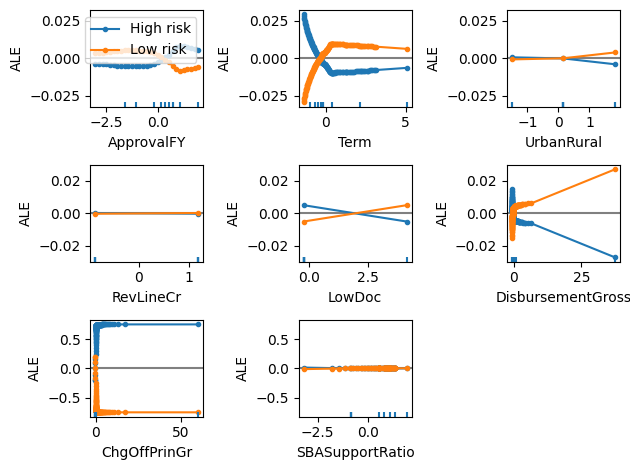

In [ ]:
plot_ale(exp, n_cols=3, sharey='row')